In [181]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.io.ascii as ascii
import astropy.io.fits as pyfits
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from IPython.display import clear_output
%matplotlib notebook

In [188]:
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 14

## Functions

In [3]:
def power(time, signal, esignal, freqmin, freqmax, nfreq):
    """
    time: time for each observation
    signal: velocity (SONG) or magnitude (TESS)
    esignal: Error on signal
    freqmin: minimum frequency
    freqmax: maximum frequency
    nfreq: number of frequencies in [freqmin, freqmax] interval
    """
    fs  = np.linspace(freqmin,freqmax,nfreq)     #The cyclic frequency
    nu  = 2*np.pi*fs                             #The angular frequency
    t   = time                                   #Seconds since the start of the timeseries
    signal = signal - np.median(signal)
    wt = 1/(esignal**2)
    
    alphas = np.zeros(len(fs))
    betas  = np.zeros(len(fs))
    
    Ps = np.zeros(len(fs))
    
    imax_fs = len(fs)
    
    for (i,f) in enumerate(fs):
        vt = nu[i]*t
        s  = np.sum(wt*signal*np.sin(vt))
        c  = np.sum(wt*signal*np.cos(vt))
        ss = np.sum(wt*np.sin(vt)**2)
        cc = np.sum(wt*np.cos(vt)**2)
        sc = np.sum(wt*np.sin(vt)*np.cos(vt))       
        
        alpha = (s*cc-c*sc)/(ss*cc-sc**2)
        beta  = (c*ss-s*sc)/(ss*cc-sc**2)
    
        P = alpha**2 + beta**2
        
        alphas[i] = alpha
        betas[i]  = beta
        Ps[i]     = P
    
    return Ps, fs, alphas, betas
    

In [5]:
def clean(signal, time, alpha, beta, P, frequency, nfrequency, f_init, f_max, nfreq):
    """
    signal: original data, radial velocity (SONG) or flux (TESS)
    time: time of the timeseries
    alpha: original alpha
    beta: original beta
    P: original power
    frequency: original frequency
    nfrequency: times the clean has to be run 
    f_init: initial frequency
    f_max: max frequency
    nfreq: number of frequencies in [freqmin, freqmax] interval
    """
    
    output_list = []
    
    for i in range(nfrequency):
        print(f'Clean {i+1}')
        P_max_test = np.where(P == np.max(P))
        alpha_max  = alpha[P_max_test][0]
        beta_max   = beta[P_max_test][0]
        f0         = frequency[P_max_test][0]
        signal     = signal - alpha_max * np.sin(2 * np.pi * f0 * time) - beta_max * np.cos(2 * np.pi * f0 * time)
        
        P,frequency,alpha,beta = power(time, signal,1,f_init,f_max,nfreq)
        
        output = {
            'signals': signal,
            'Ps': P,
            'fs': frequency,
            'alphas': alpha,
            'betas': beta,
            'f0' : f0,
        }
        
        output_list.append(output)
    
    
    
    return output_list

## Test function

In [87]:
time = np.linspace(0,200,10000)
signal = np.sin(3*time)+np.sin(5*time)+np.sin(7*time)

In [90]:
time = time-np.median(time)
P,f,a,b = power(time,signal,1,2/(2*np.pi),10/(2*np.pi),1000)

<IPython.core.display.Javascript object>


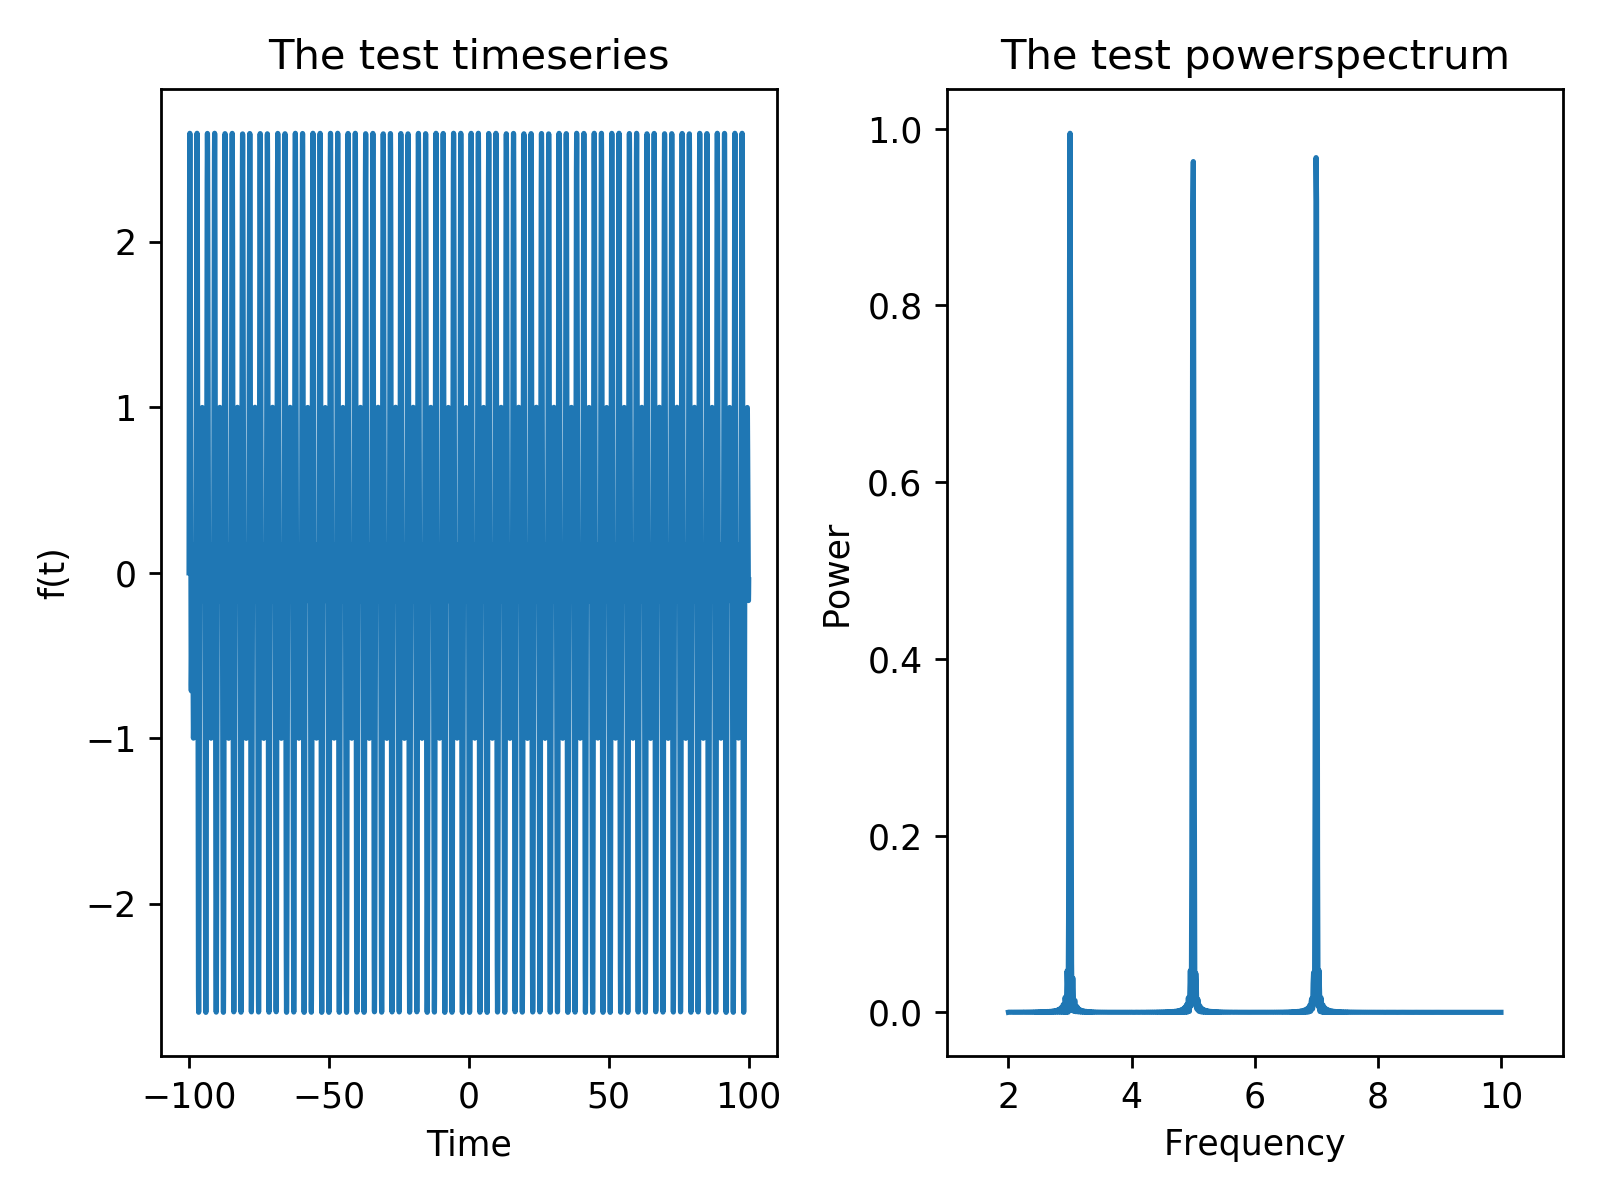

In [113]:
figtest,test = plt.subplots(1,2,tight_layout=True)
test[0].set_title('The test timeseries')
test[0].set_xlabel('Time')
test[0].set_ylabel('f(t)')
test[0].plot(time, signal)


test[1].set_title('The test powerspectrum')
test[1].set_xlabel('Frequency')
test[1].set_ylabel('Power')
test[1].set_xlim(1,11)
test[1].plot(2*np.pi*f, P)

figtest.savefig('Figure/Testfunc.pdf')

In [99]:
test_clean = clean(signal,time,a,b,P,f,3,2/(2*np.pi),10/(2*np.pi),1000)

Clean 1
Clean 2
Clean 3


<IPython.core.display.Javascript object>


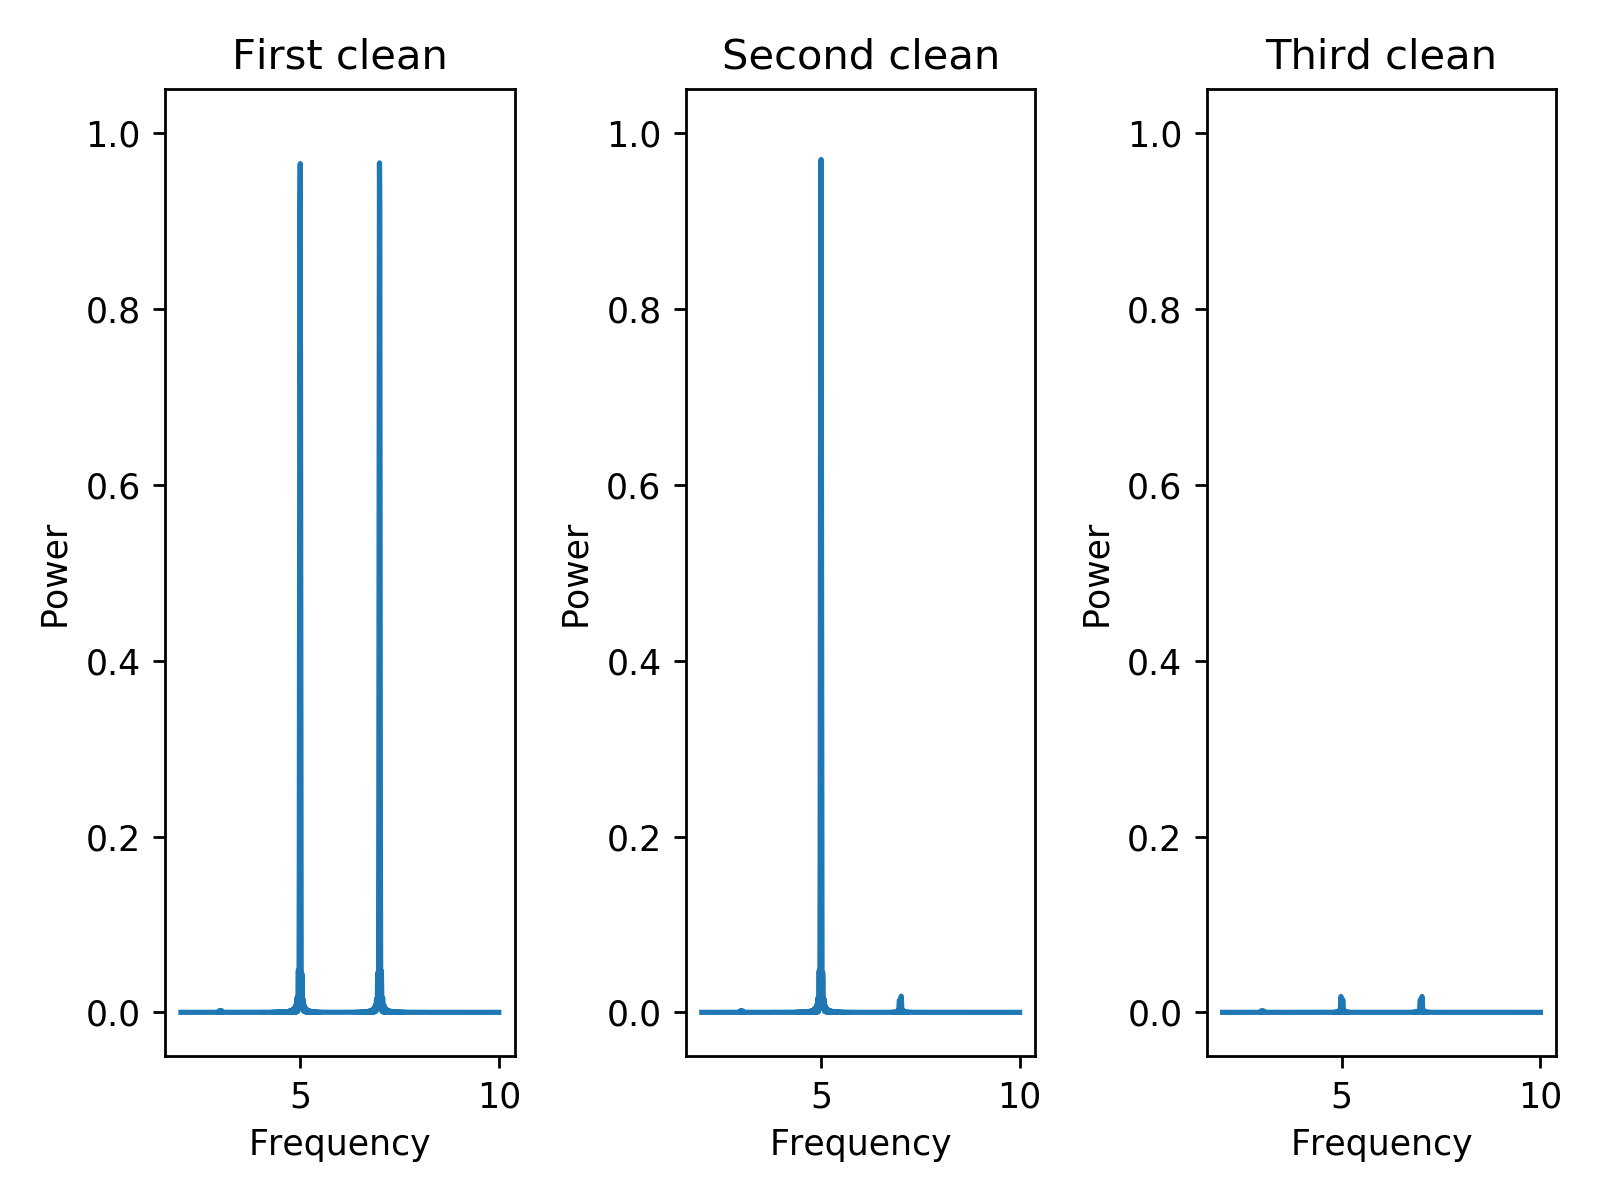

In [144]:
figtest1,test1 = plt.subplots(1,3,tight_layout=True)
test1[0].set_title('First clean')
test1[0].set_xlabel('Frequency')
test1[0].set_ylabel('Power')
test1[0].set_ylim(-0.05,1.05)
test1[0].plot(2*np.pi*test_clean[0]['fs'],test_clean[0]['Ps'])

test1[1].set_title('Second clean')
test1[1].set_xlabel('Frequency')
test1[1].set_ylabel('Power')
test1[1].set_ylim(-0.05,1.05)
test1[1].plot(2*np.pi*test_clean[1]['fs'],test_clean[1]['Ps'])

test1[2].set_title('Third clean')
test1[2].set_xlabel('Frequency')
test1[2].set_ylabel('Power')
test1[2].set_ylim(-0.05,1.05)
test1[2].plot(2*np.pi*test_clean[2]['fs'],test_clean[2]['Ps'])

figtest1.savefig('Figure/Testclean.pdf')

## Import of data

In [6]:
t0 = 2457000.0
# TESS data
tess      = pyfits.getdata( 'TESS/gam_psc_tess.fits',1 )
tess_x    = tess['time']
tess_y    = tess['flux']
tt        = np.where( np.isnan( tess_y ) == False )[0]
tess_time = tess_x[tt]
tesstime2 = tess_x[tt]
tess_flux = tess_y[tt]
tessflux2 = tess_y[tt]
kk = np.where( (tess_flux < 1.12e7) & (tess_flux > 1.1e7) & (np.abs( tess_flux - np.roll( tess_flux, 1 ))  < 2400 ))[0] 
tess_fluxen = 25000.0*((tess_flux[kk] / np.median( tess_flux[kk]))-1)
tess_time   = tess_time[kk]
tess_sort   = np.where((tess_fluxen < 65) & (tess_fluxen > -65))
tess_flux   = tess_fluxen[tess_sort]
tess_time   = tess_time[tess_sort]
tess_sorted = np.where((tess_time < 2454) | (tess_time > 2456.59))
tess_flux   = tess_flux[tess_sorted]
tess_time   = tess_time[tess_sorted]
tess_timefinal = 86400.0 * (tess_time - np.median(tess_time))


# SONG OT
ot        = ascii.read( 'SONG/HIP114971_2022-02-02T094858.txt')
time_ot   = ot['col3']-t0
rv_ot     = ot['col5']  #+14480.0
timemask  = np.where(time_ot>2000)   #Finding the data at that are at the same time as TESS og Mt Kent
time_ot_masked = time_ot[timemask]   
rv_ot_masked   = rv_ot[timemask]     
ii = np.where( (time_ot > 2400) & (np.abs( rv_ot - np.roll(rv_ot,1)   ) < 12.0) & (time_ot < 2540))[0]
#rv_ot = rv_ot-np.median(rv_ot)
rv_ot = rv_ot[ii]
time_ot = time_ot[ii]
time_otfinal = 86400.0 * (time_ot - np.median(time_ot))

cc     = np.polyfit( time_ot, rv_ot, 2 )
rv_ot  = rv_ot - np.polyval( cc, time_ot)

# SONG MtK
mk        = ascii.read( 'SONG/mtkent.txt' )
time_mk   = mk['col1']-t0
rv_mk     = mk['col2']#-np.median(rv_mk)
jj = np.where( np.abs( rv_mk - np.roll(rv_mk,1)   ) < 33.0 )[0]
cc_mk    = np.polyfit( time_mk[jj], rv_mk[jj], 2 )
rv_mk = rv_mk[jj] #- np.polyval( cc_mk, time_mk[jj])
time_mk = time_mk[jj]
time_mkfinal = 86400.0 * (time_mk - np.median(time_mk))


<IPython.core.display.Javascript object>


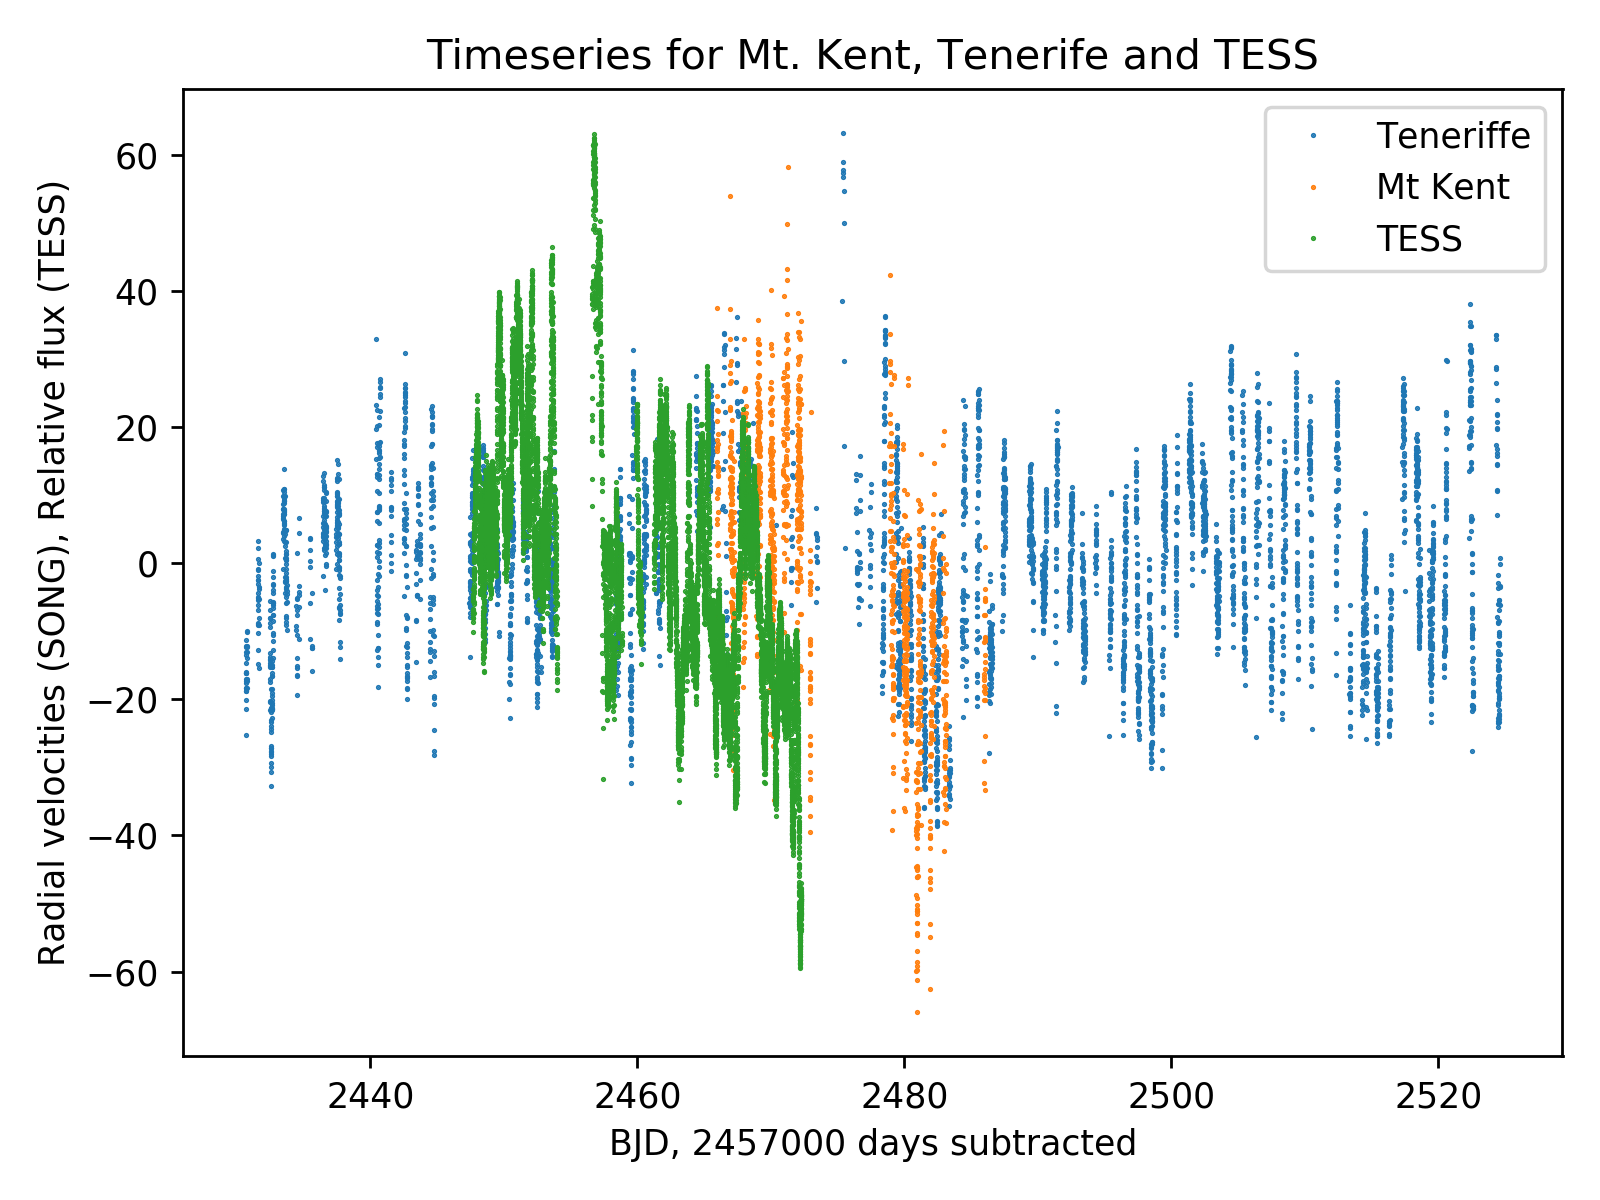

In [145]:
fig,ax = plt.subplots(1,1,tight_layout=True)
ax.set_xlabel('BJD, 2457000 days subtracted')
ax.set_ylabel('Radial velocities (SONG), Relative flux (TESS)')
ax.set_title('Timeseries for Mt. Kent, Tenerife and TESS')
ax.plot(time_ot, rv_ot,'o',ms=0.5,label='Teneriffe')
ax.plot(time_mk,rv_mk,'o',ms=0.5, label='Mt Kent')
ax.plot(tess_time,tess_flux,'o',ms=0.5,label='TESS')
#ax.plot(time_SONG2,rv_SONG2,'o',ms=0.5,label='SONG')
ax.legend()
fig.savefig('Figure/Timeseries.pdf')

# Powerspecra

## Tenerife

In [9]:
finit_ot = 1e-6
fmax_ot  = 200*1e-6
err_ot   = 0.0*rv_ot + 1.0 
npt      = 20000

P_ot,f_ot,a_ot,b_ot = power(time_otfinal,rv_ot, err_ot, finit_ot, fmax_ot, npt)

In [10]:
#cleaning

ot_clean = clean(rv_ot,time_otfinal,a_ot,b_ot,P_ot,f_ot,50,finit_ot, fmax_ot, 20000)

Clean 1
Clean 2
Clean 3
Clean 4
Clean 5
Clean 6
Clean 7
Clean 8
Clean 9
Clean 10
Clean 11
Clean 12
Clean 13
Clean 14
Clean 15
Clean 16
Clean 17
Clean 18
Clean 19
Clean 20
Clean 21
Clean 22
Clean 23
Clean 24
Clean 25
Clean 26
Clean 27
Clean 28
Clean 29
Clean 30
Clean 31
Clean 32
Clean 33
Clean 34
Clean 35
Clean 36
Clean 37
Clean 38
Clean 39
Clean 40
Clean 41
Clean 42
Clean 43
Clean 44
Clean 45
Clean 46
Clean 47
Clean 48
Clean 49
Clean 50


<IPython.core.display.Javascript object>


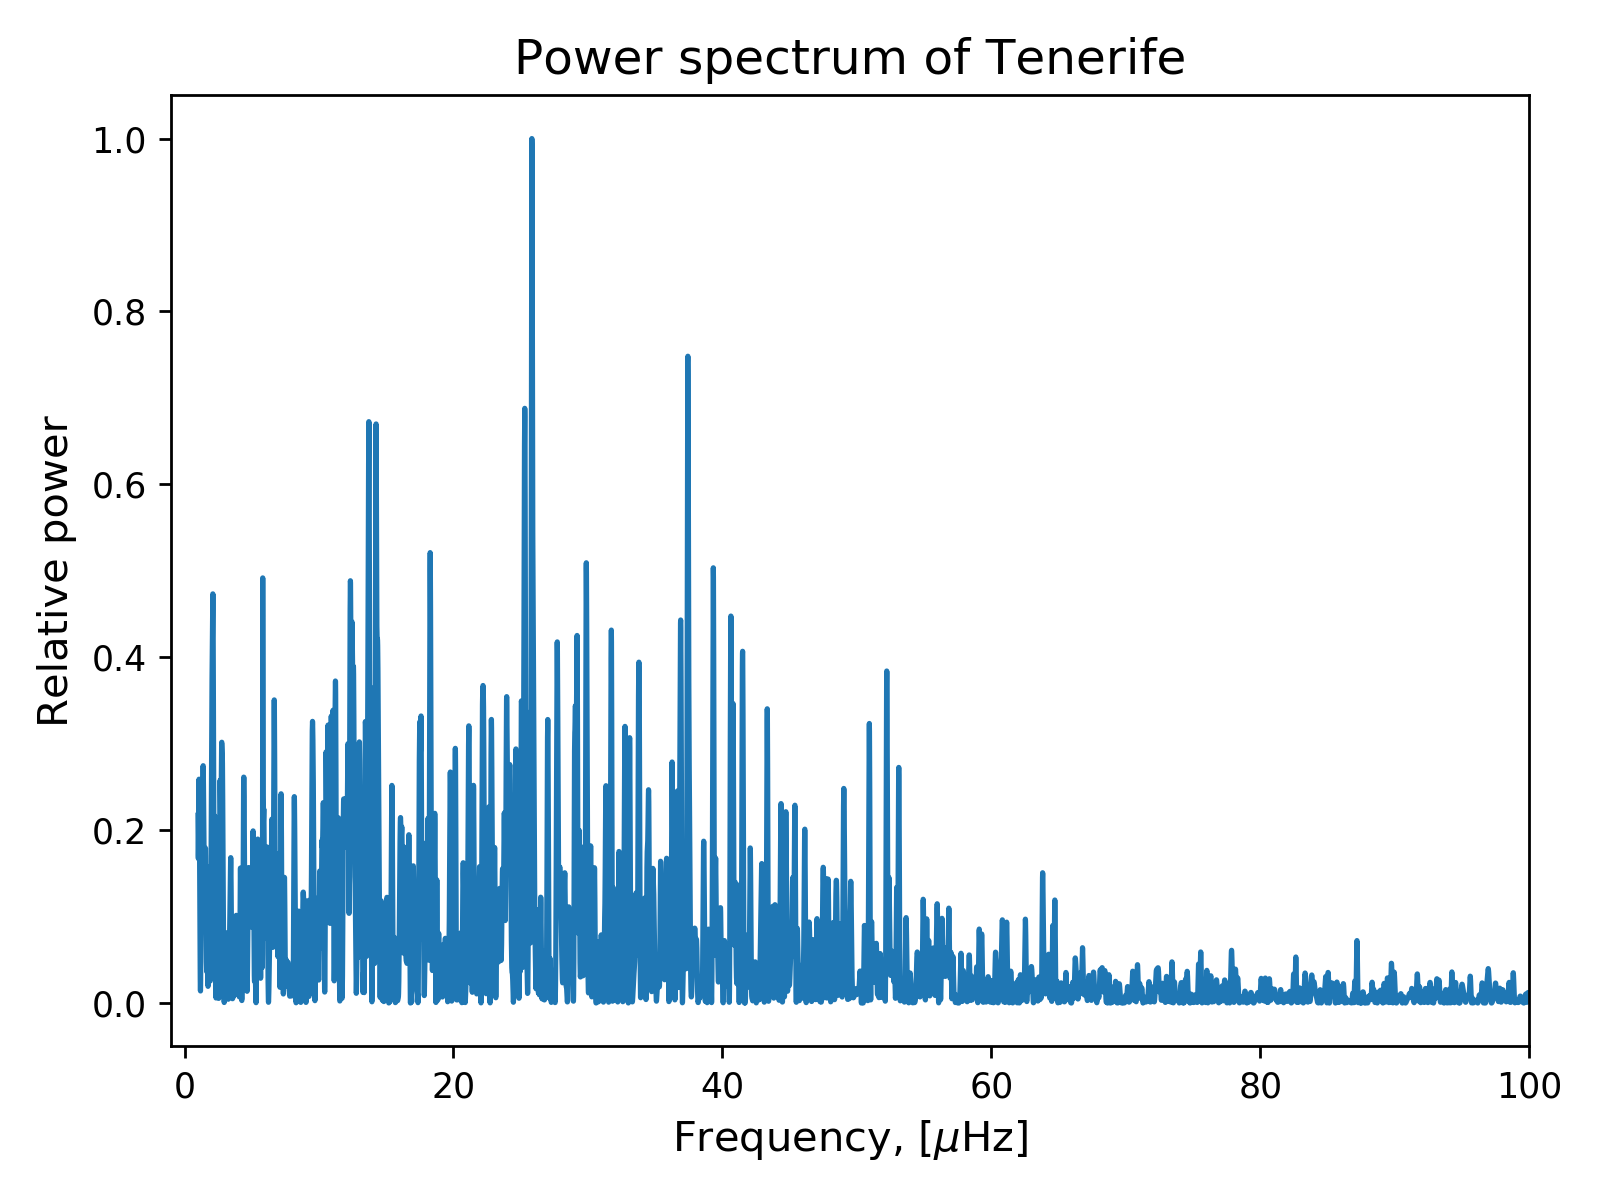

In [220]:
fig2,ax2 = plt.subplots(1,1,tight_layout=True)
ax2.set_title('Power spectrum of Tenerife')
ax2.set_ylim(-0.05,1.05)
ax2.set_xlim(-1,100)
ax2.set_ylabel('Relative power')
ax2.set_xlabel('Frequency, [$\mu$Hz]')
ax2.plot(f_ot*1e6,P_ot/np.max(P_ot))
fig2.savefig('Figure/PS_ot.pdf')

<IPython.core.display.Javascript object>


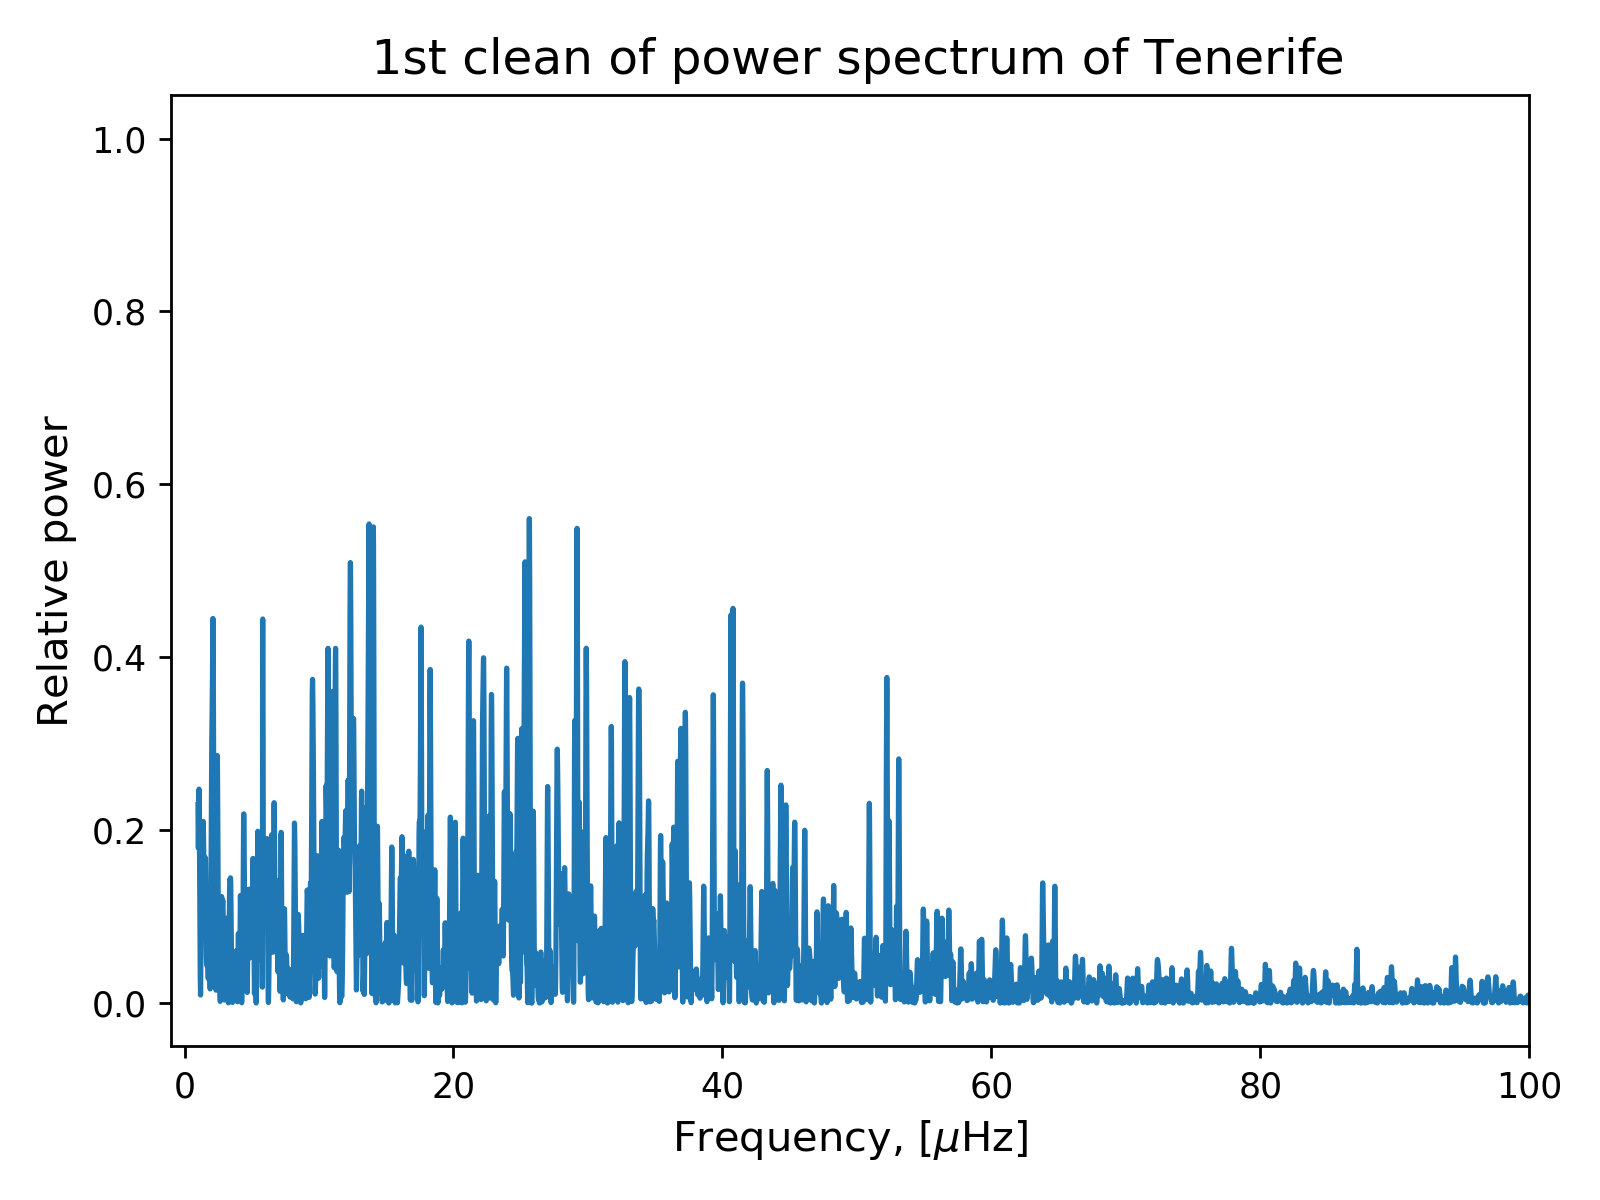

In [221]:
fig21,ax21 = plt.subplots(1,1,tight_layout=True)
ax21.set_ylim(-0.05,1.05)
ax21.set_xlim(-1,100)
ax21.set_title(' 1st clean of power spectrum of Tenerife')
ax21.set_ylabel('Relative power')
ax21.set_xlabel('Frequency, [$\mu$Hz]')
ax21.plot(ot_clean[0]['fs']*1e6,ot_clean[0]['Ps']/np.max(P_ot))
#ax2.plot(ot_clean[-1]['fs']*1e6,ot_clean[-1]['Ps'], label = 'last clean', alpha = 0.5)
fig21.savefig('Figure/clean1_ot.pdf')

<IPython.core.display.Javascript object>


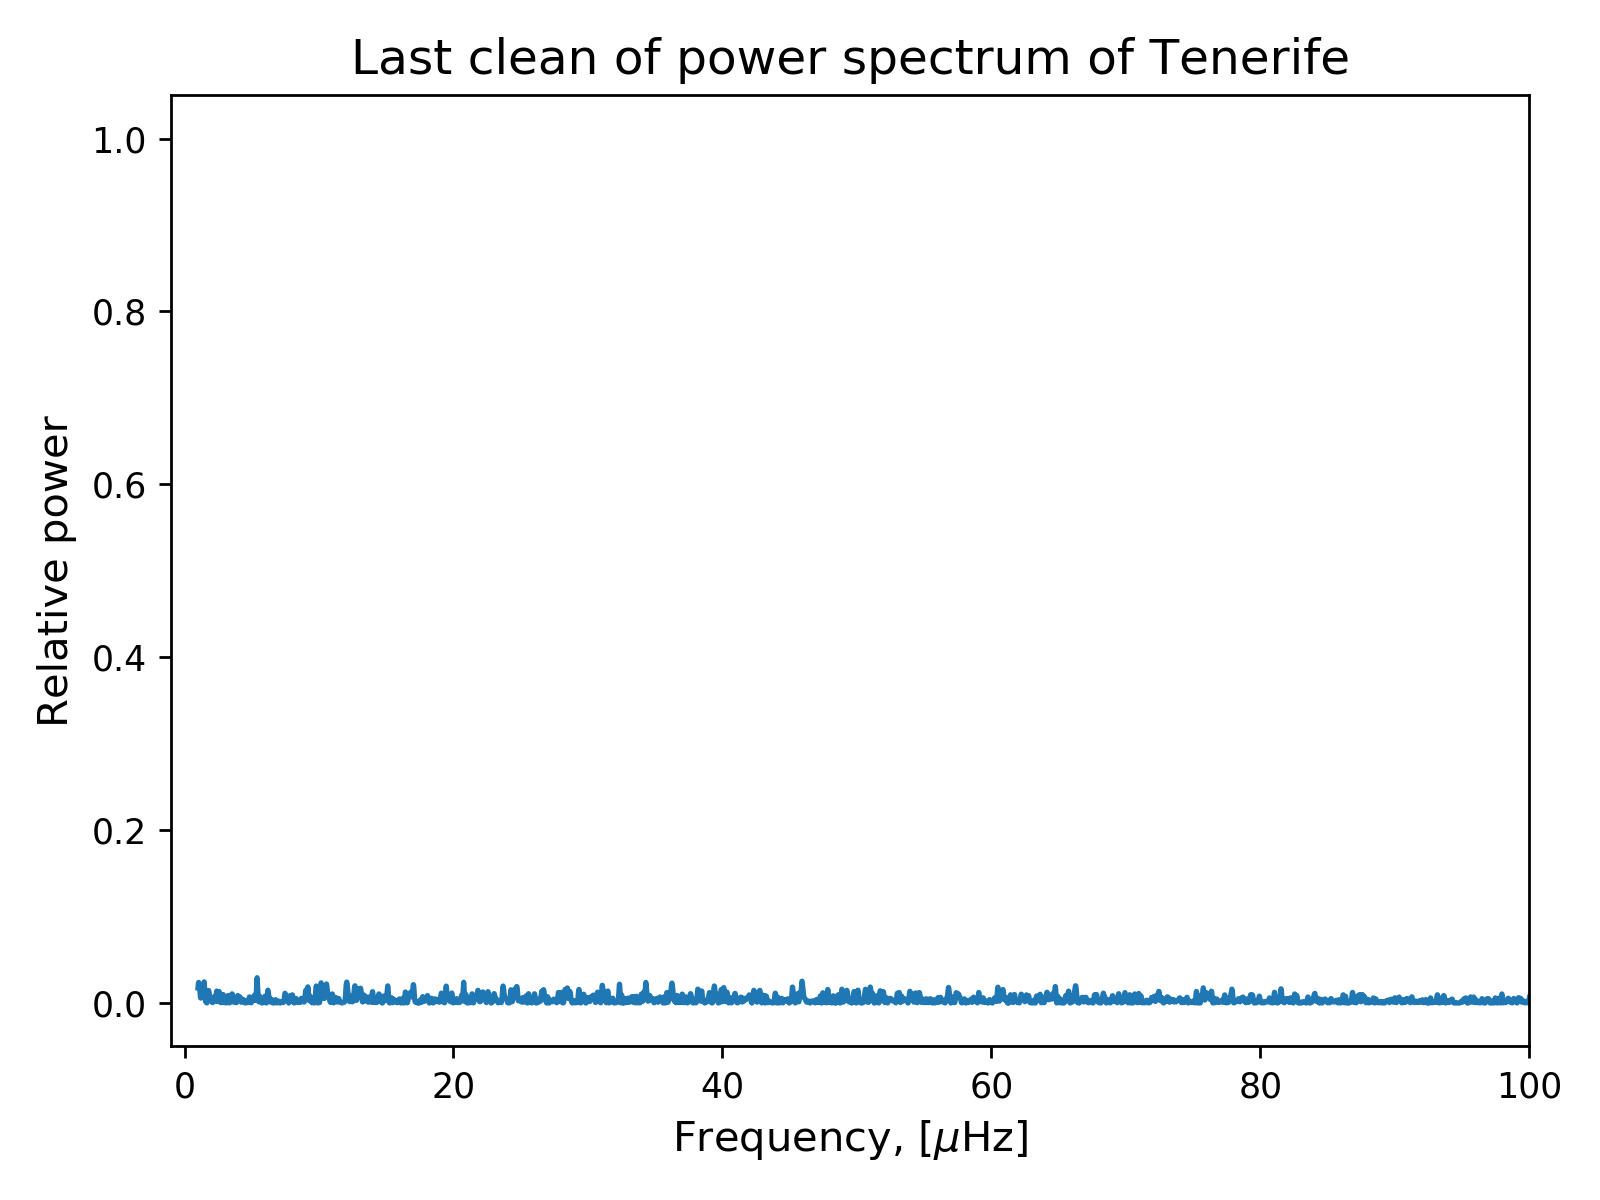

In [222]:
fig22,ax22 = plt.subplots(1,1,tight_layout=True)
ax22.set_ylim(-0.05,1.05)
ax22.set_xlim(-1,100)
ax22.set_title('Last clean of power spectrum of Tenerife')
ax22.set_ylabel('Relative power')
ax22.set_xlabel('Frequency, [$\mu$Hz]')
ax22.plot(ot_clean[-1]['fs']*1e6,ot_clean[-1]['Ps']/np.max(P_ot))
fig22.savefig('Figure/cleanlast_ot.pdf')

## Mt Kent

In [12]:
finit_mk = 1e-6
fmax_mk  = 200*1e-6
err_mk   = 0.0*rv_mk + 1.0 
npt      = 20000

P_mk,f_mk,a_mk,b_mk = power(time_mkfinal,rv_mk, err_mk, finit_mk, fmax_mk, npt)

In [13]:
#cleaning

mk_clean = clean(rv_mk,time_mkfinal,a_mk,b_mk,P_mk,f_mk,50,finit_mk, fmax_mk, npt)

Clean 1
Clean 2
Clean 3
Clean 4
Clean 5
Clean 6
Clean 7
Clean 8
Clean 9
Clean 10
Clean 11
Clean 12
Clean 13
Clean 14
Clean 15
Clean 16
Clean 17
Clean 18
Clean 19
Clean 20
Clean 21
Clean 22
Clean 23
Clean 24
Clean 25
Clean 26
Clean 27
Clean 28
Clean 29
Clean 30
Clean 31
Clean 32
Clean 33
Clean 34
Clean 35
Clean 36
Clean 37
Clean 38
Clean 39
Clean 40
Clean 41
Clean 42
Clean 43
Clean 44
Clean 45
Clean 46
Clean 47
Clean 48
Clean 49
Clean 50


<IPython.core.display.Javascript object>


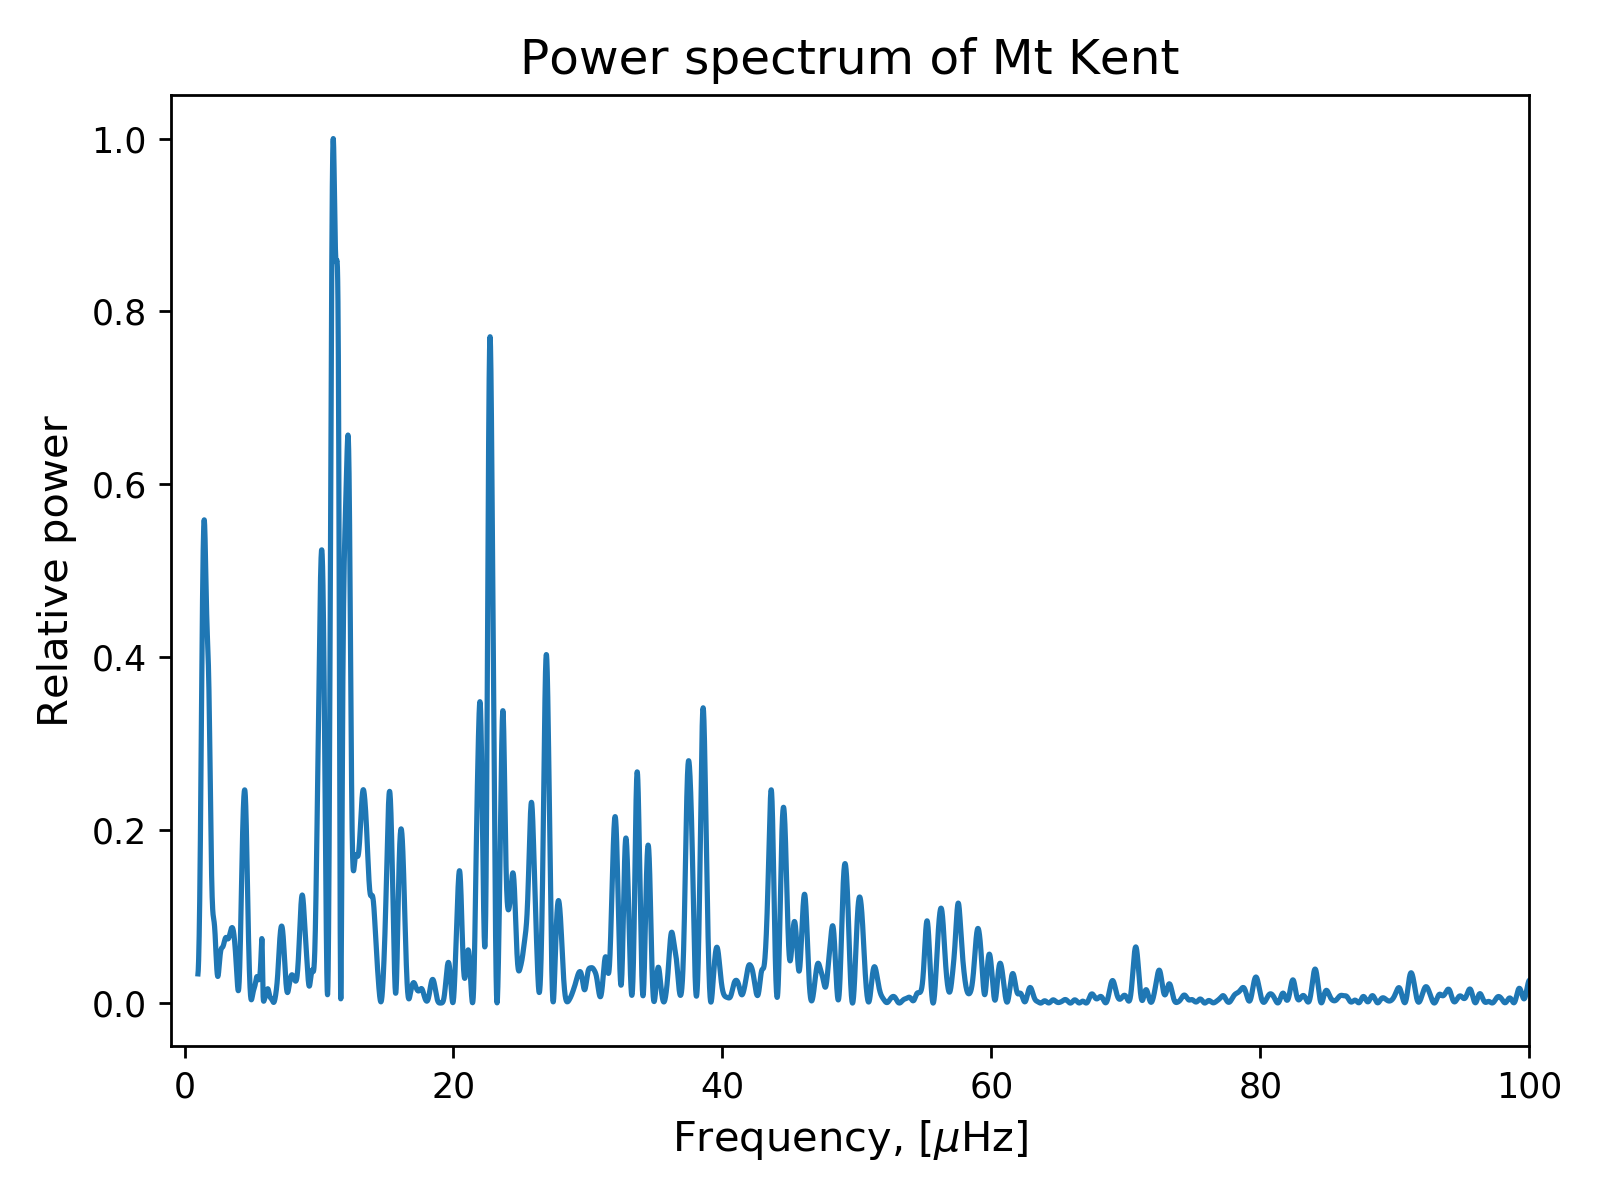

In [223]:
fig3,ax3 = plt.subplots(1,1,tight_layout=True)
ax3.set_ylim(-0.05,1.05)
ax3.set_xlim(-1,100)
ax3.set_title('Power spectrum of Mt Kent')
ax3.set_ylabel('Relative power')
ax3.set_xlabel('Frequency, [$\mu$Hz]')
ax3.plot(f_mk*1e6,P_mk/np.max(P_mk))
fig3.savefig('Figure/PS_mk.pdf')
#ax3.plot(mk_clean[0]['fs']*1e6,mk_clean[0]['Ps'], label = '1st clean', alpha = 0.5)
#ax3.plot(mk_clean[-1]['fs']*1e6,mk_clean[-1]['Ps'], label = 'last clean', alpha = 0.5)

<IPython.core.display.Javascript object>


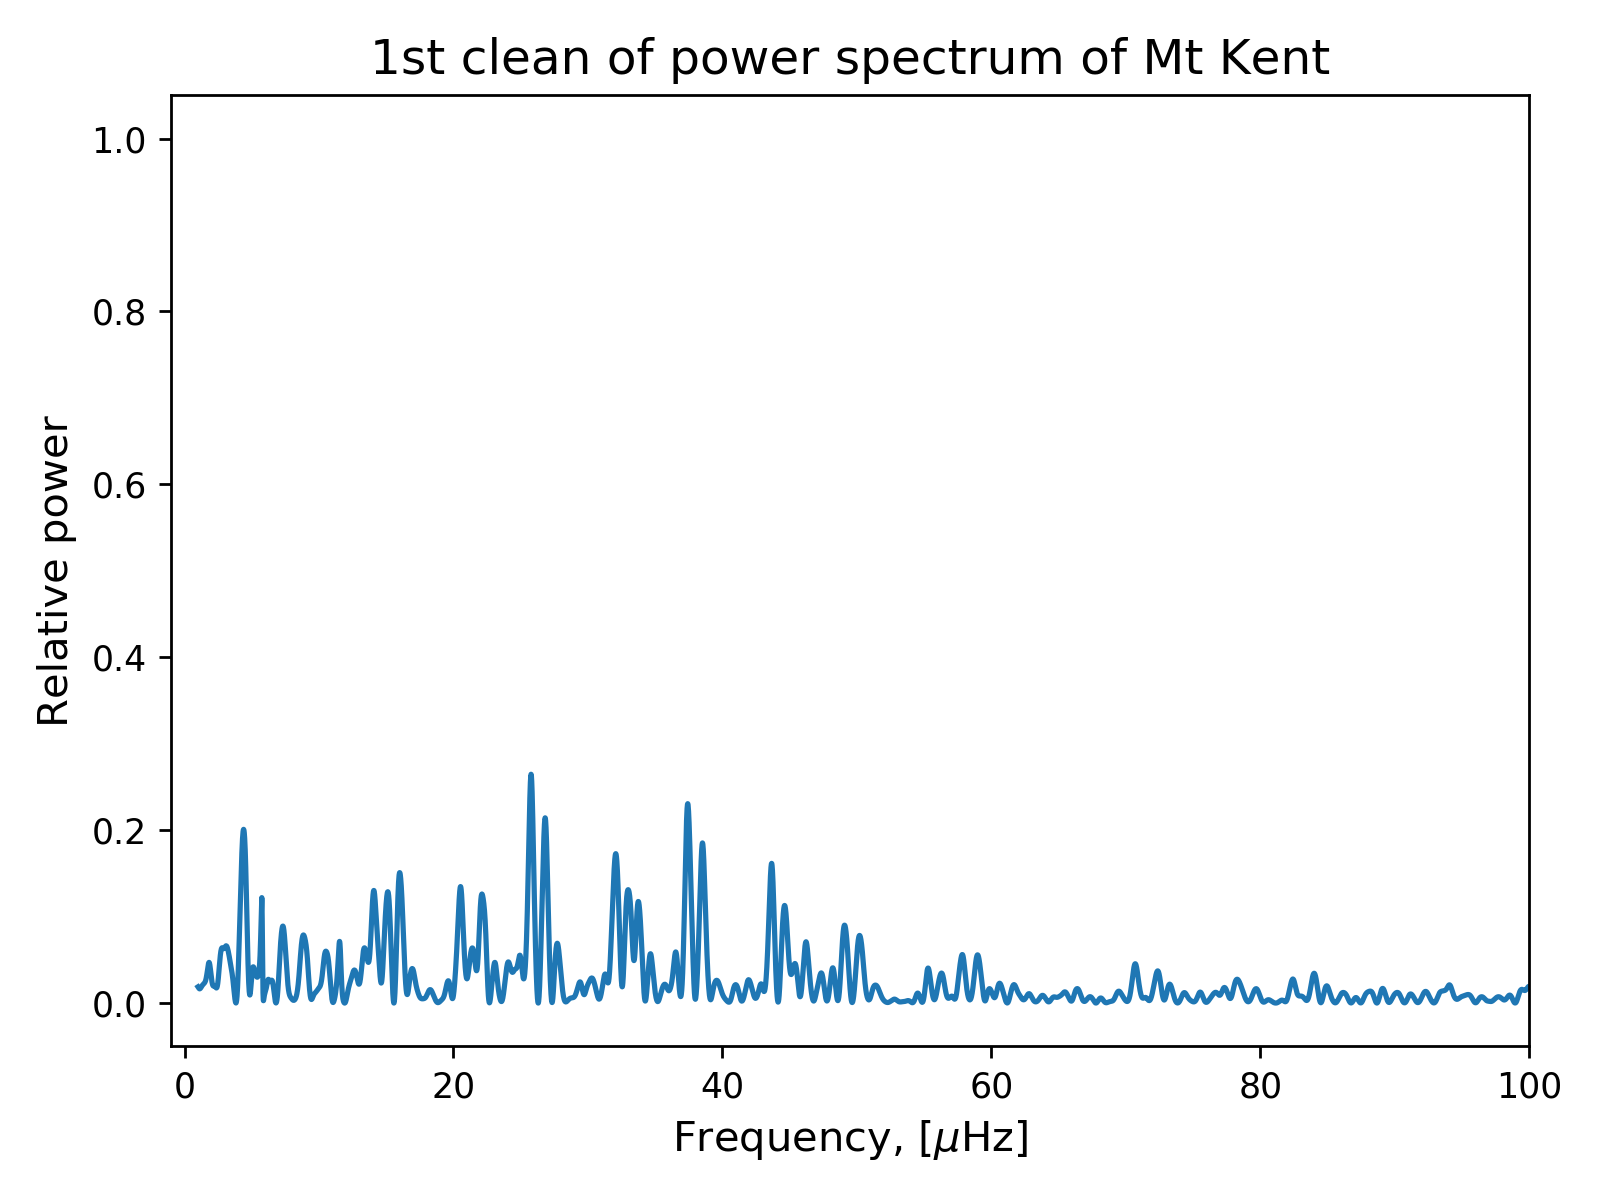

In [224]:
fig31,ax31 = plt.subplots(1,1,tight_layout=True)
ax31.set_ylim(-0.05,1.05)
ax31.set_xlim(-1,100)
ax31.set_title('1st clean of power spectrum of Mt Kent')
ax31.set_ylabel('Relative power')
ax31.set_xlabel('Frequency, [$\mu$Hz]')
ax31.plot(mk_clean[0]['fs']*1e6,mk_clean[0]['Ps']/np.max(P_mk))
fig31.savefig('Figure/clean1_mk.pdf')

<IPython.core.display.Javascript object>


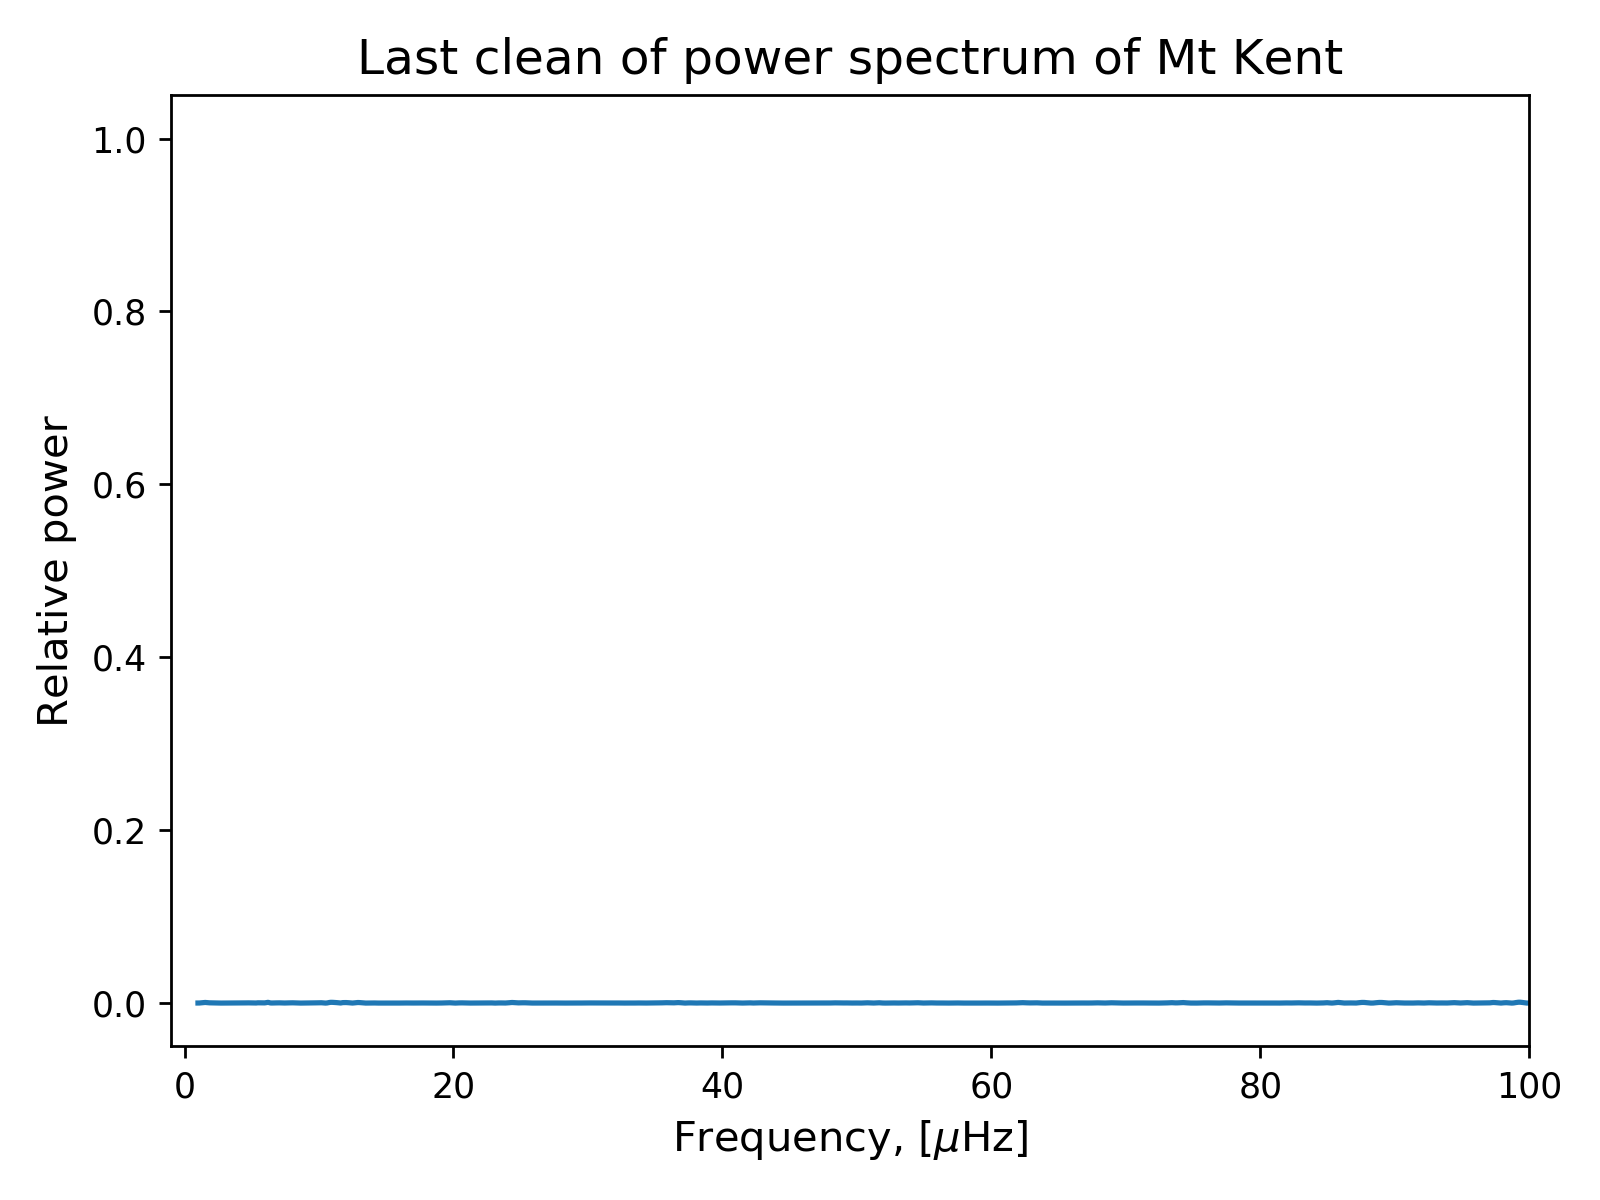

In [225]:
fig32,ax32 = plt.subplots(1,1,tight_layout=True)
ax32.set_ylim(-0.05,1.05)
ax32.set_xlim(-1,100)
ax32.set_title('Last clean of power spectrum of Mt Kent')
ax32.set_ylabel('Relative power')
ax32.set_xlabel('Frequency, [$\mu$Hz]')
ax32.plot(mk_clean[-1]['fs']*1e6,mk_clean[-1]['Ps']/np.max(P_mk))
fig32.savefig('Figure/cleanlast_mk.pdf')

## Tenerife and Mt Kent combined

In [30]:
rv_SONG  = np.append( rv_mk, rv_ot )
time_SONG  = np.append( time_mk, time_ot )
time_SONGfinal = 86400.0 * (time_SONG - np.median(time_SONG))
erv2 = 0.0 * rv_SONG + 1.0

P_SONG,f_SONG,a_SONG,b_SONG = power(time_SONGfinal,rv_SONG,erv2,finit_ot,fmax_ot,npt)

In [31]:
#cleaning, skal køres igen

SONG_cleaning = clean(rv_SONG,time_SONGfinal,a_SONG,b_SONG,P_SONG,f_SONG,50,finit_ot,fmax_ot,npt)

Clean 1
Clean 2
Clean 3
Clean 4
Clean 5
Clean 6
Clean 7
Clean 8
Clean 9
Clean 10
Clean 11
Clean 12
Clean 13
Clean 14
Clean 15
Clean 16
Clean 17
Clean 18
Clean 19
Clean 20
Clean 21
Clean 22
Clean 23
Clean 24
Clean 25
Clean 26
Clean 27
Clean 28
Clean 29
Clean 30
Clean 31
Clean 32
Clean 33
Clean 34
Clean 35
Clean 36
Clean 37
Clean 38
Clean 39
Clean 40
Clean 41
Clean 42
Clean 43
Clean 44
Clean 45
Clean 46
Clean 47
Clean 48
Clean 49
Clean 50


In [165]:
SONG_cleaning[0]['f0']*1e6

25.82649132456623

<IPython.core.display.Javascript object>


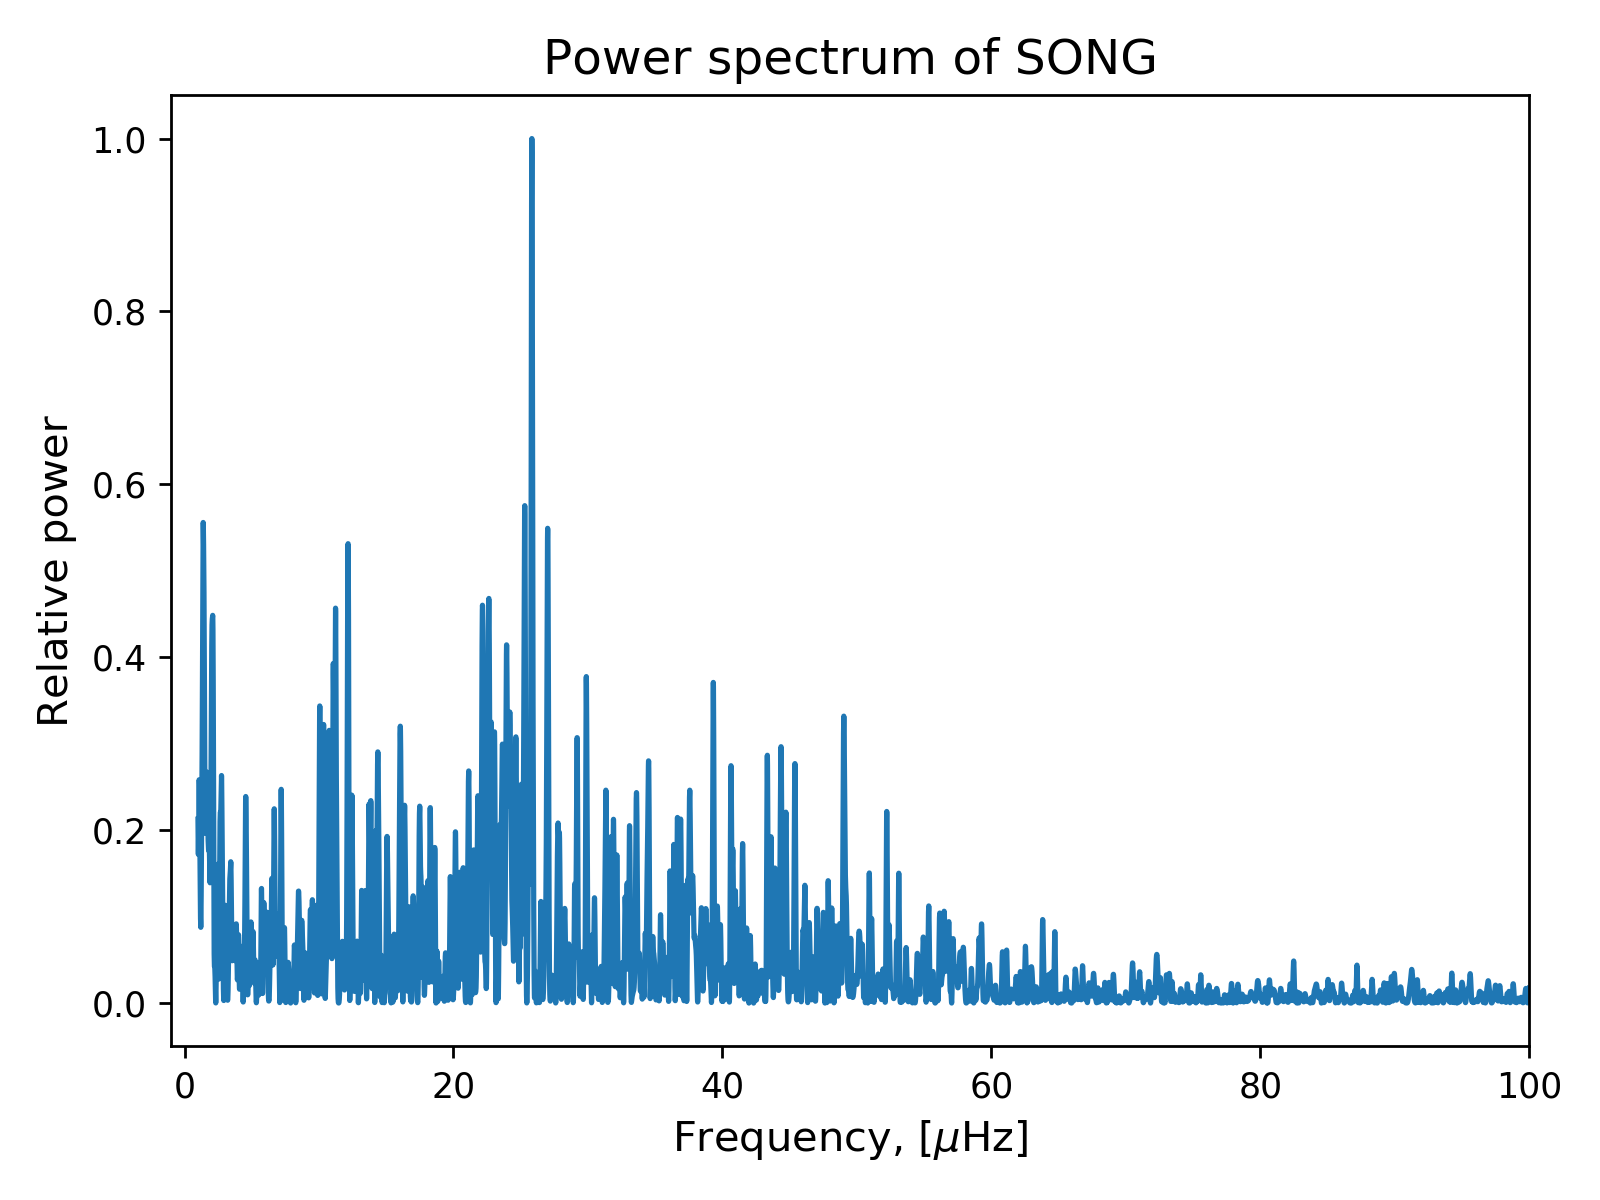

In [226]:
SONGfig,SONGax = plt.subplots(1,1,tight_layout=True)
SONGax.set_ylim(-0.05,1.05)
SONGax.set_xlim(-1,100)
SONGax.set_title('Power spectrum of SONG')
SONGax.set_ylabel('Relative power')
SONGax.set_xlabel('Frequency, [$\mu$Hz]')
SONGax.plot(f_SONG*1e6,P_SONG/np.max(P_SONG))
SONGfig.savefig('Figure/PS_SONG.pdf')

<IPython.core.display.Javascript object>


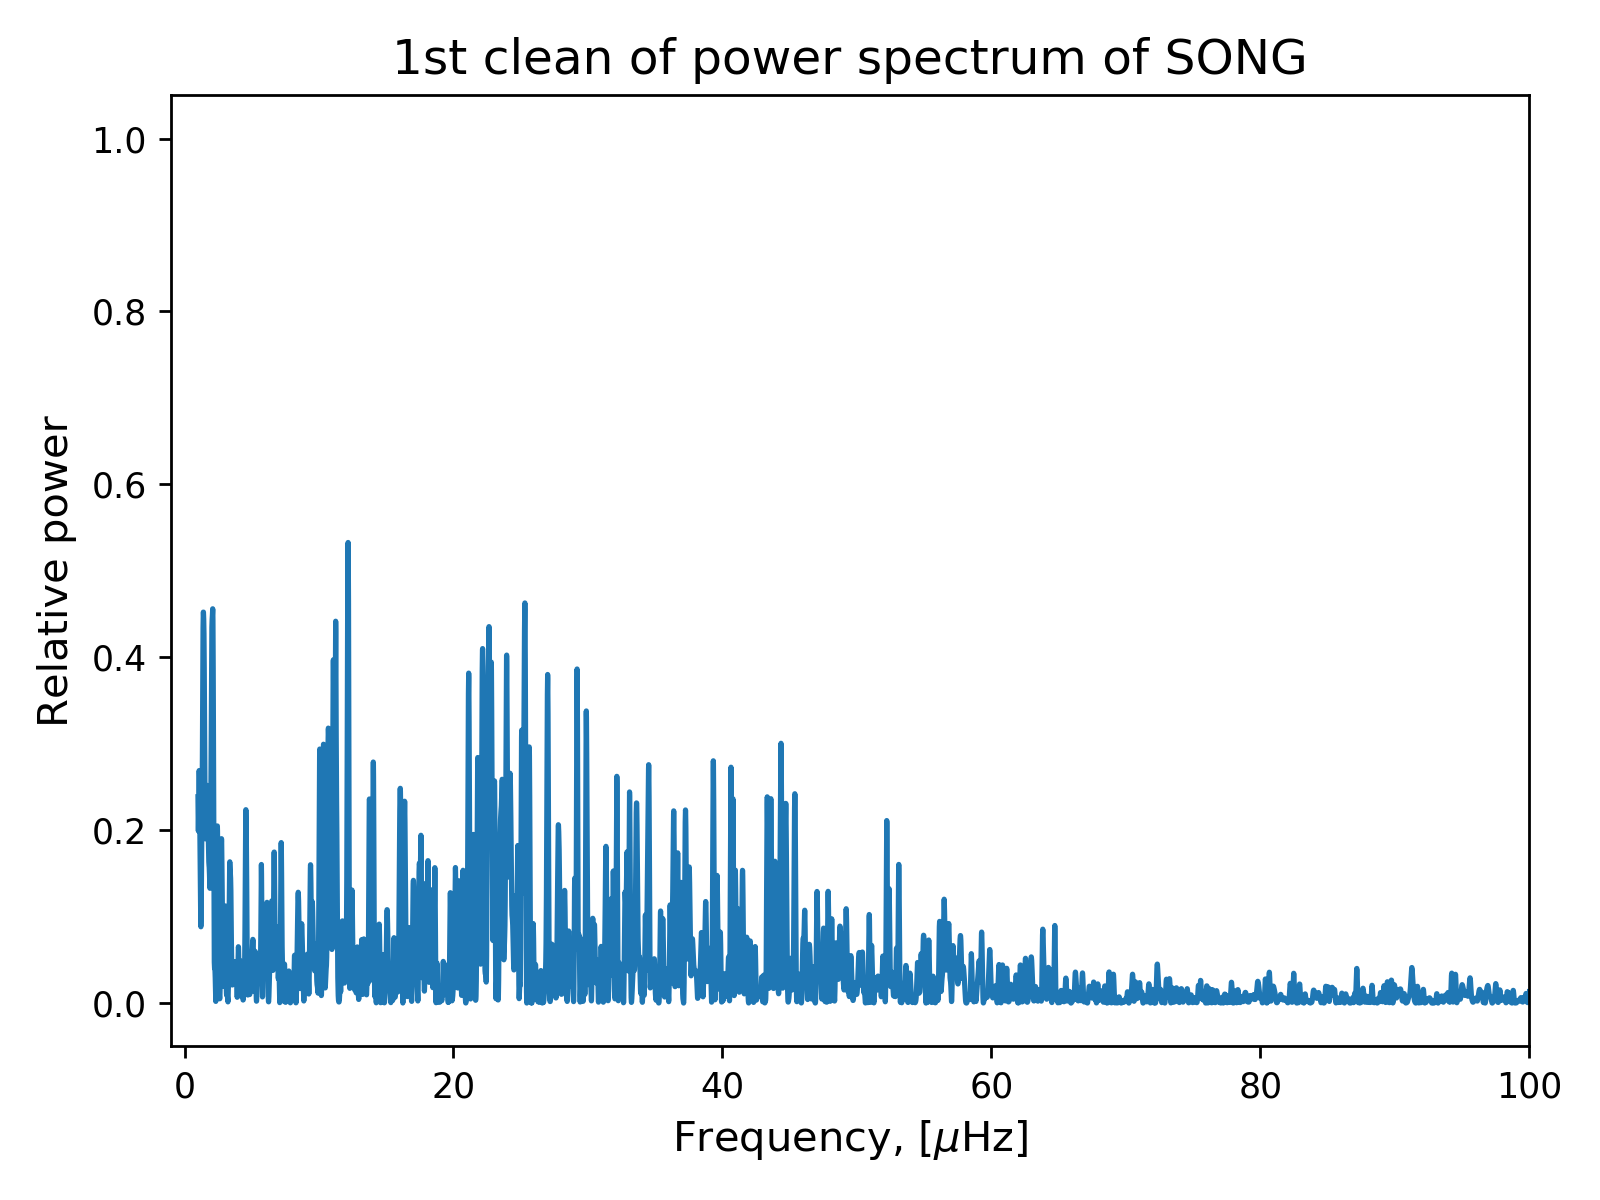

In [227]:
SONG1fig,SONG1ax = plt.subplots(1,1,tight_layout=True)
SONG1ax.set_ylim(-0.05,1.05)
SONG1ax.set_xlim(-1,100)
SONG1ax.set_title('1st clean of power spectrum of SONG')
SONG1ax.set_ylabel('Relative power')
SONG1ax.set_xlabel('Frequency, [$\mu$Hz]')
SONG1ax.plot(SONG_cleaning[0]['fs']*1e6,SONG_cleaning[0]['Ps']/np.max(P_SONG))
SONG1fig.savefig('Figure/clean1_SONG.pdf')

<IPython.core.display.Javascript object>


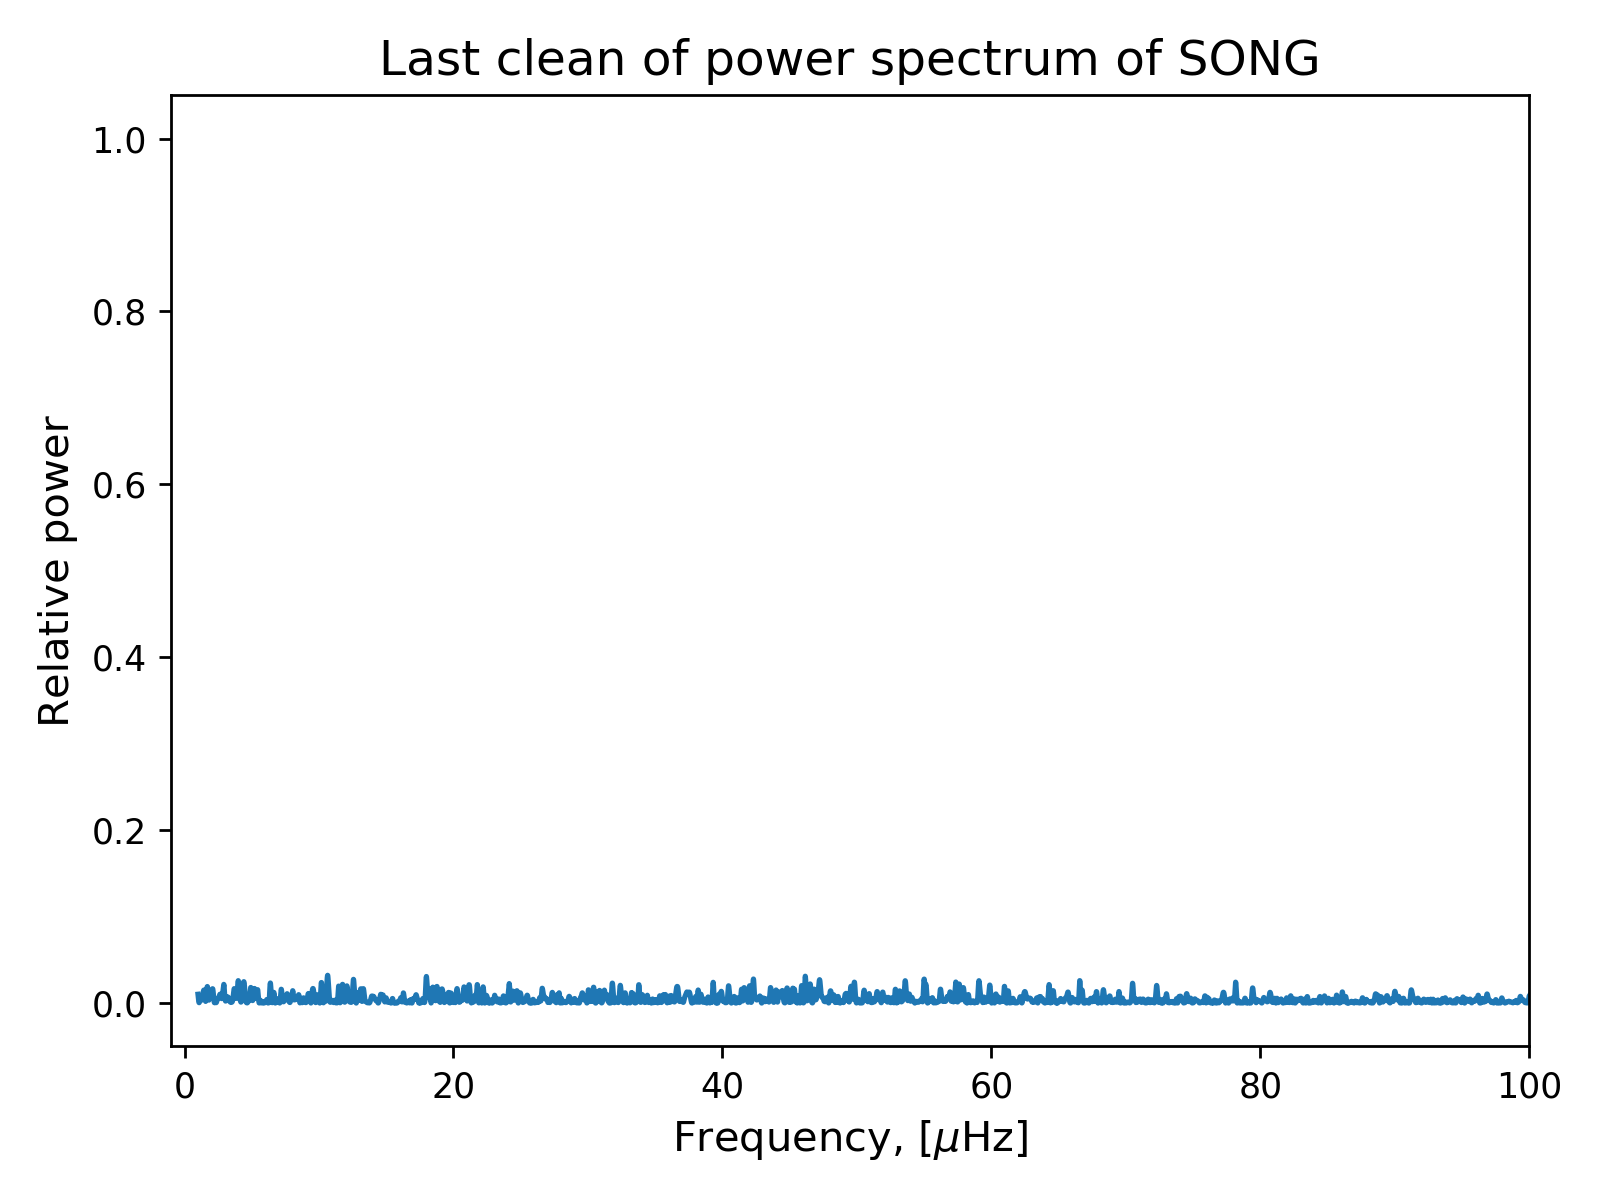

In [228]:
SONG2fig,SONG2ax = plt.subplots(1,1,tight_layout=True)
SONG2ax.set_ylim(-0.05,1.05)
SONG2ax.set_xlim(-1,100)
SONG2ax.set_title('Last clean of power spectrum of SONG')
SONG2ax.set_ylabel('Relative power')
SONG2ax.set_xlabel('Frequency, [$\mu$Hz]')
SONG2ax.plot(SONG_cleaning[-1]['fs']*1e6,SONG_cleaning[-1]['Ps']/np.max(P_SONG))
SONG2fig.savefig('Figure/cleanlast_SONG.pdf')

<IPython.core.display.Javascript object>


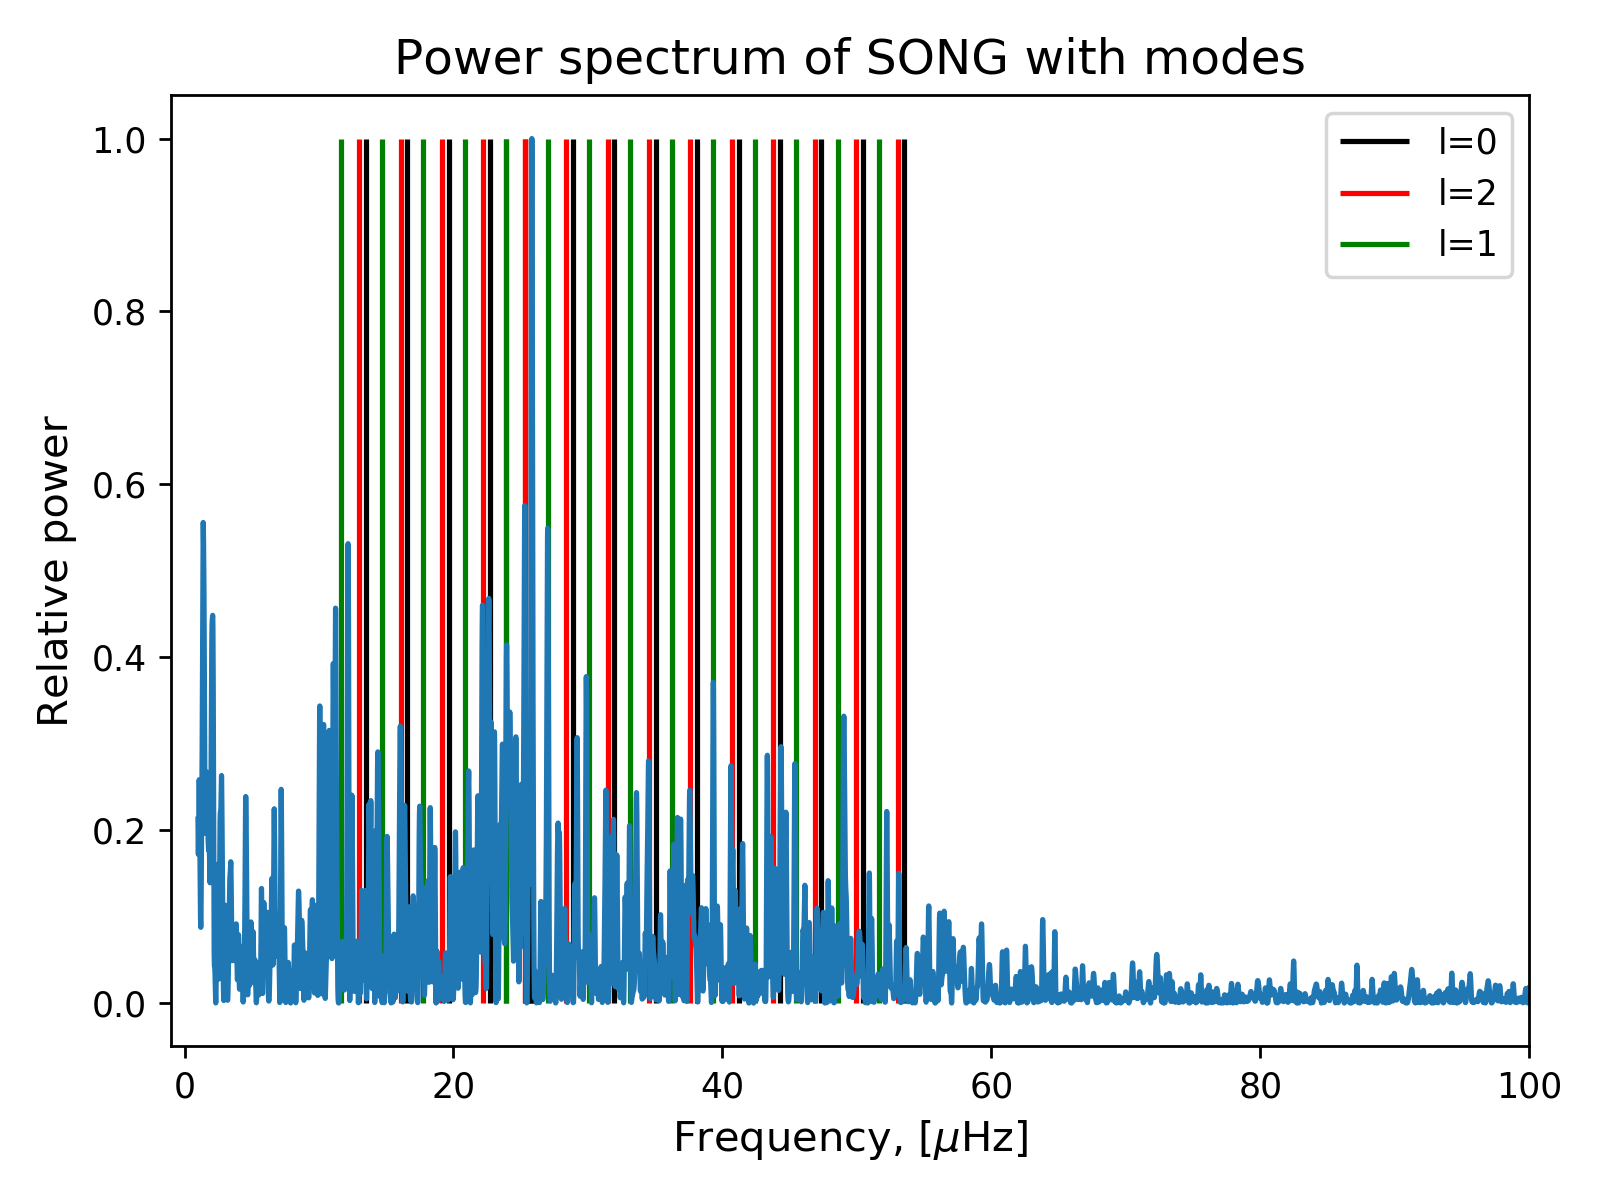

In [232]:
SONG3fig,SONG3ax = plt.subplots(1,1,tight_layout=True)
SONG3ax.set_xlim(10,60)
SONG3ax.set_xlim(-1,100)
SONG3ax.set_title('Power spectrum of SONG with modes')
SONG3ax.set_ylabel('Relative power')
SONG3ax.set_xlabel('Frequency, [$\mu$Hz]')
SONG3ax.plot(f_SONG*1e6,P_SONG/np.max(P_SONG))

v0 = 25.8
dv = 3.08
v2 = 25.3
v1 = 23.92
for i in np.arange(-4,10):
    SONG3ax.vlines(v0+i*dv,0,1)
    SONG3ax.vlines(v2+i*dv,0,1,'r')
    SONG3ax.vlines(v1+i*dv,0,1,'g')
SONG3ax.vlines(v0,0.0,1, label = 'l=0')
SONG3ax.vlines(v2,0.0,1,'r', label ='l=2')
SONG3ax.vlines(v1,0.0,1,'g', label ='l=1')




SONG3ax.legend()

SONG3fig.savefig('Figure/SONGmodes.pdf')

In [125]:
SONG_smoothed = gaussian_filter(P_SONG,sigma =500)

<IPython.core.display.Javascript object>


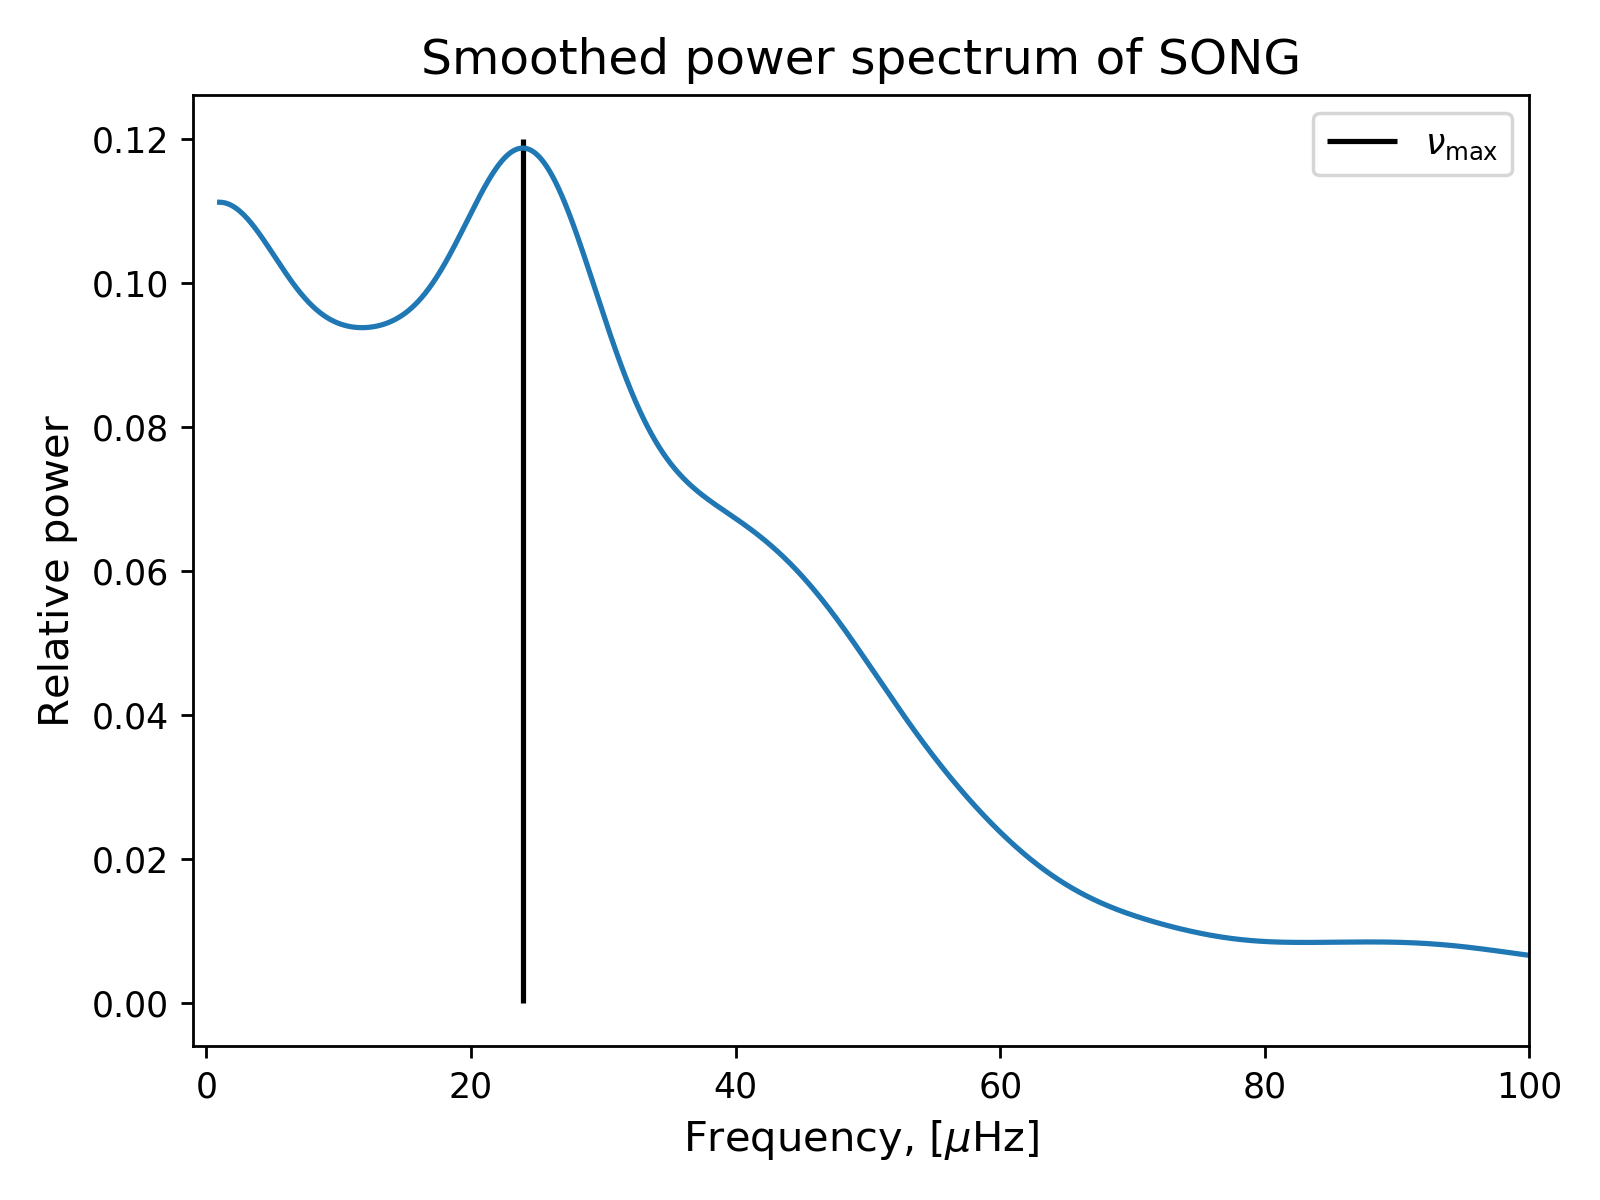

In [258]:
SONG4fig,SONG4ax = plt.subplots(1,1,tight_layout=True)
SONG4ax.set_xlim(-1,100)
SONG4ax.set_title('Smoothed power spectrum of SONG')
SONG4ax.set_ylabel('Relative power')
SONG4ax.set_xlabel('Frequency, [$\mu$Hz]')
SONG4ax.plot(f_SONG*1e6,SONG_smoothed/np.max(P_SONG))
SONG4ax.vlines(vmax,0,0.12, label = r'$\nu_\max$')
SONG4ax.legend()

SONG4fig.savefig('Figure/numax')

## TESS

In [46]:
mag = 10.0-2.5*np.log10(tess_flux + 60)
cc_TESS = np.polyfit( tess_timefinal, mag, 2 )
fitmag  = np.polyval( cc_TESS, tess_timefinal )
err_tess = 0.0*mag+1.0

finit_tess = 1e-6
fmax_tess  = 200*1e-6 
npt      = 20000


P_TESS, f_TESS, a_TESS, b_TESS = power( tess_timefinal, mag - fitmag, err_tess, finit_tess, fmax_tess, npt )

In [47]:
#cleaning

tess_clean = clean(mag - fitmag, tess_timefinal, a_TESS, b_TESS, P_TESS, f_TESS, 50, finit_tess, fmax_tess, npt)

Clean 1
Clean 2
Clean 3
Clean 4
Clean 5
Clean 6
Clean 7
Clean 8
Clean 9
Clean 10
Clean 11
Clean 12
Clean 13
Clean 14
Clean 15
Clean 16
Clean 17
Clean 18
Clean 19
Clean 20
Clean 21
Clean 22
Clean 23
Clean 24
Clean 25
Clean 26
Clean 27
Clean 28
Clean 29
Clean 30
Clean 31
Clean 32
Clean 33
Clean 34
Clean 35
Clean 36
Clean 37
Clean 38
Clean 39
Clean 40
Clean 41
Clean 42
Clean 43
Clean 44
Clean 45
Clean 46
Clean 47
Clean 48
Clean 49
Clean 50


<IPython.core.display.Javascript object>


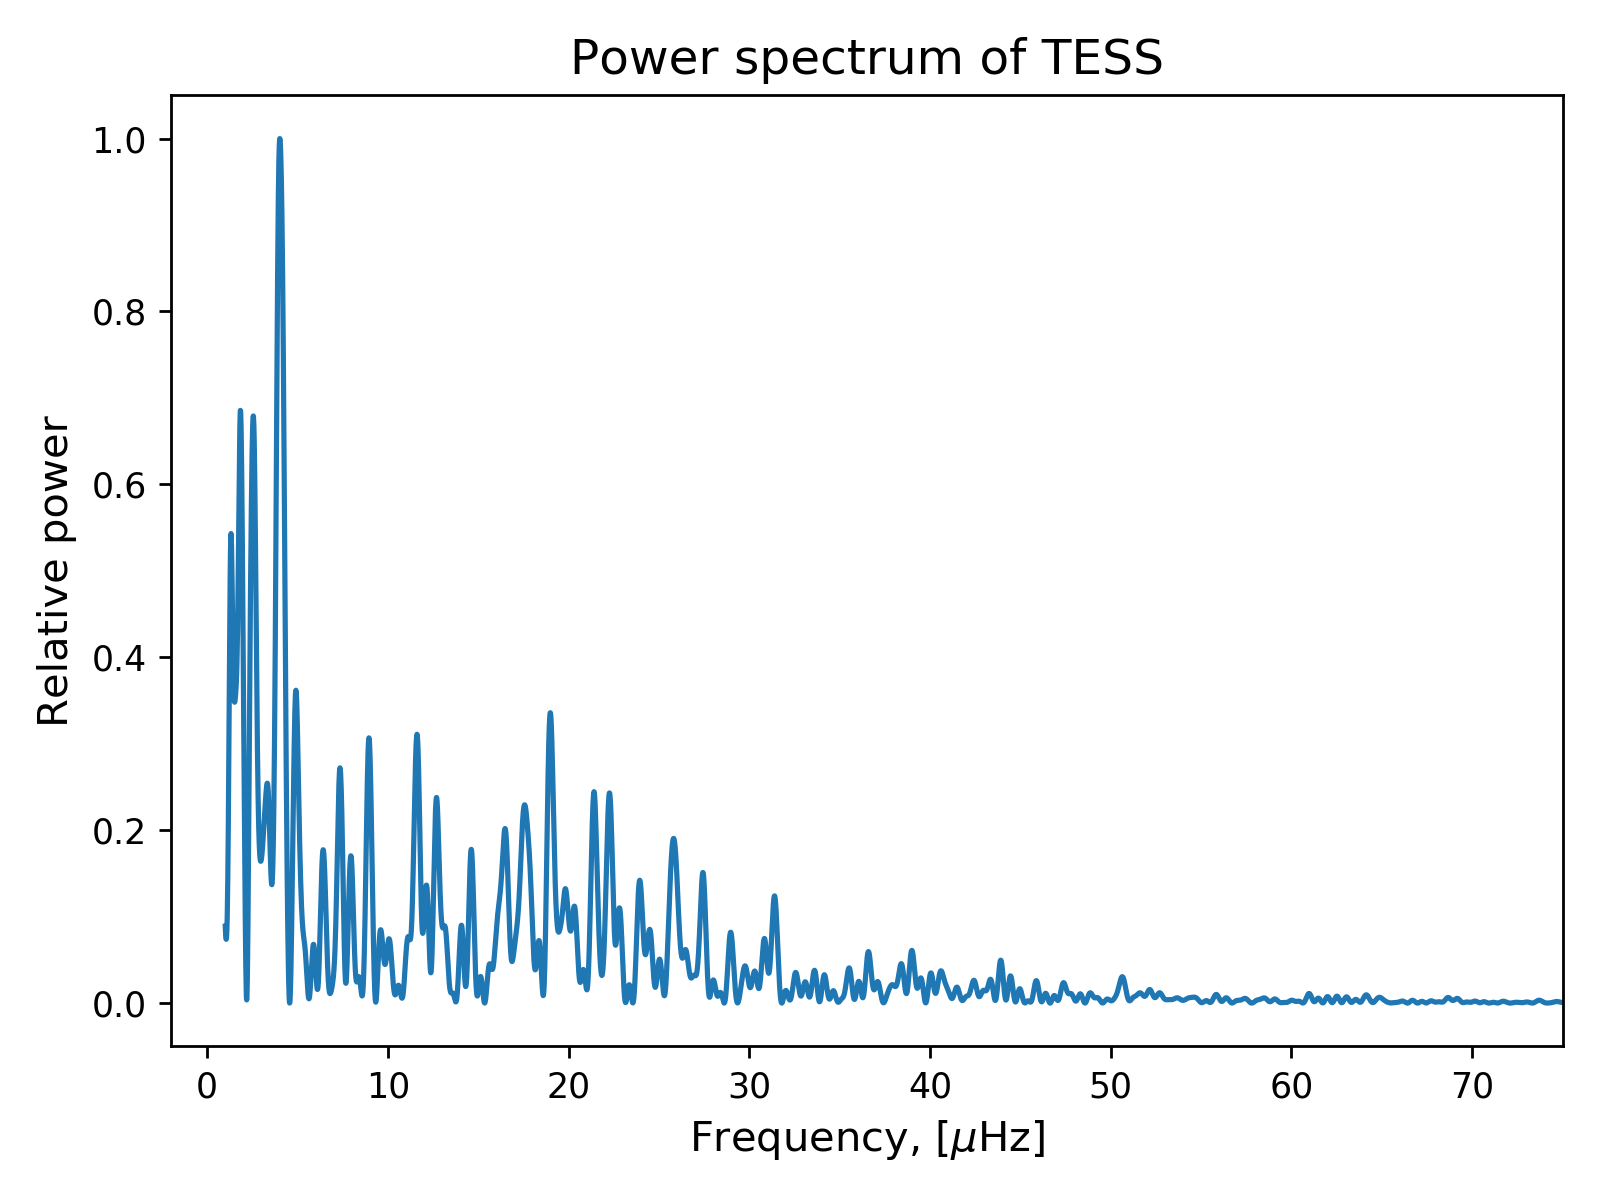

In [207]:
TESSfig,TESSax = plt.subplots(1,1,tight_layout=True)
TESSax.set_xlim(-2,75 )
TESSax.set_ylim(-0.05,1.05)
TESSax.set_title('Power spectrum of TESS')
TESSax.set_ylabel('Relative power')
TESSax.set_xlabel('Frequency, [$\mu$Hz]')
TESSax.plot(f_TESS *1e6, P_TESS/np.max(P_TESS))
TESSfig.savefig('Figure/PS_TESS.pdf')

<IPython.core.display.Javascript object>


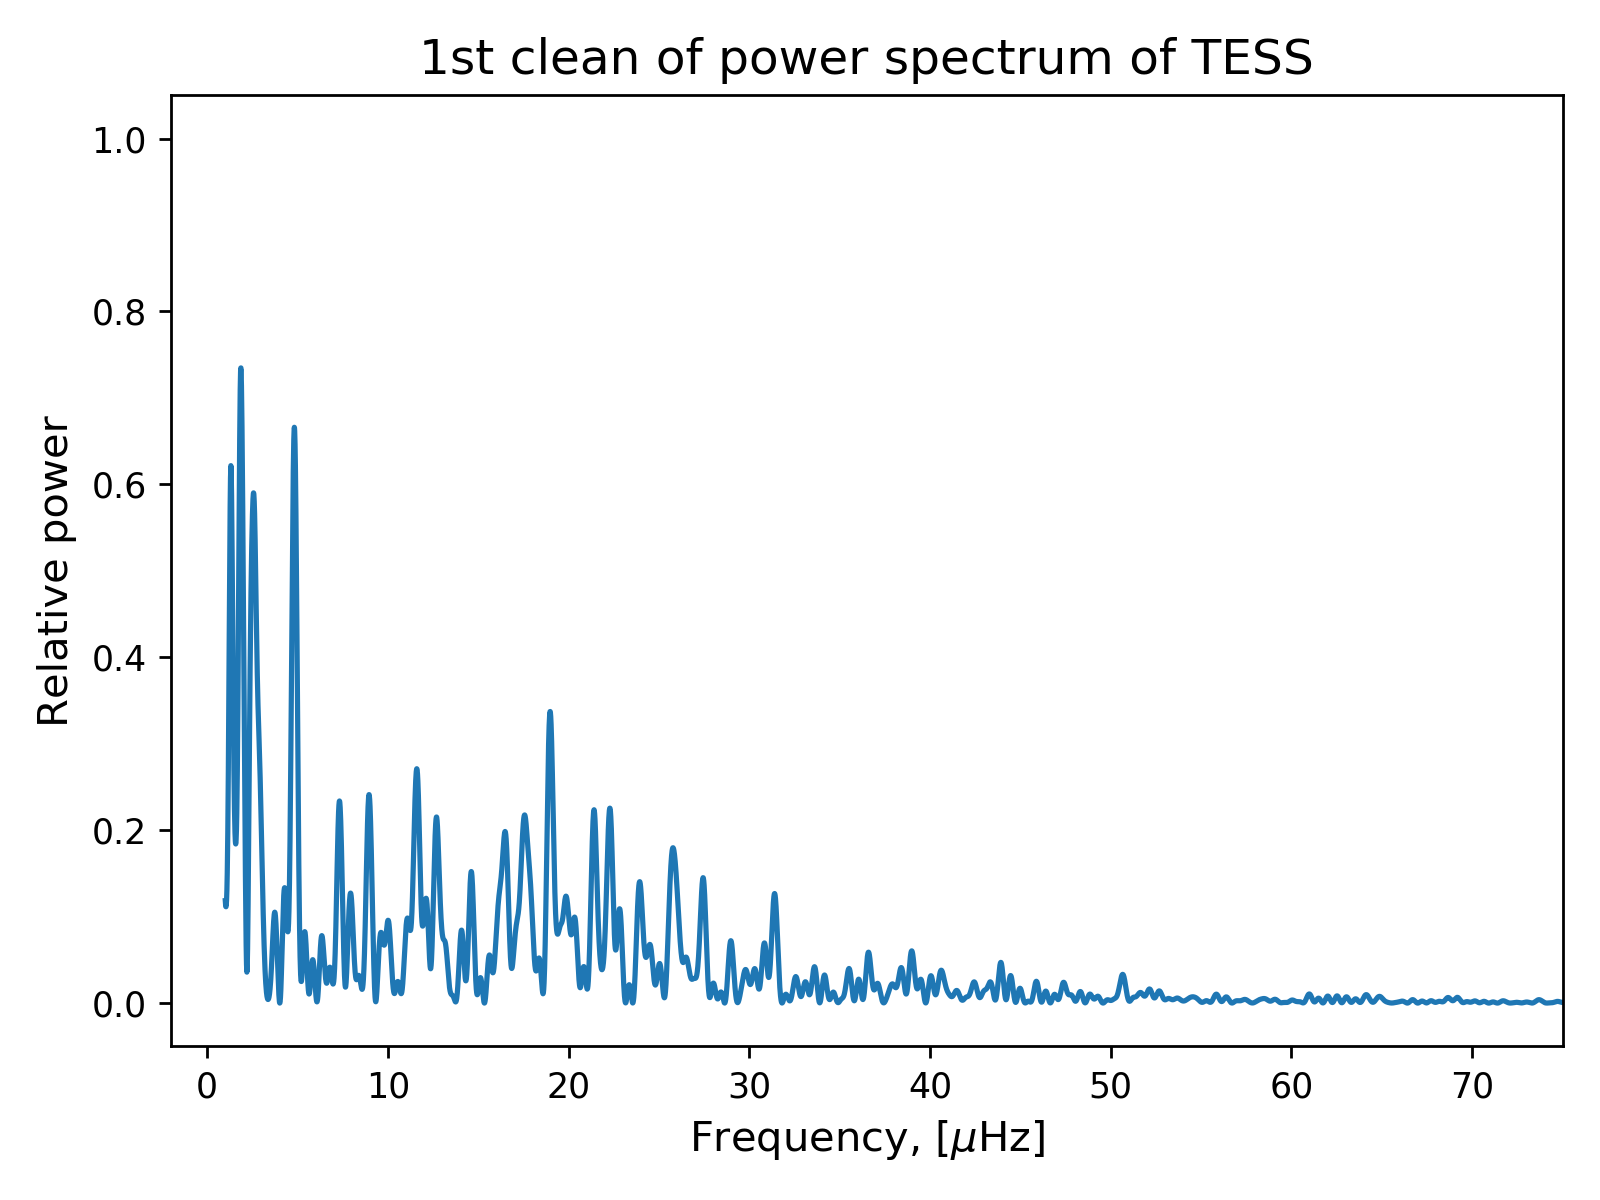

In [206]:
TESS1fig,TESS1ax = plt.subplots(1,1,tight_layout=True)
TESS1ax.set_xlim(-2,75)
TESS1ax.set_ylim(-0.05,1.05)
TESS1ax.set_title('1st clean of power spectrum of TESS')
TESS1ax.set_ylabel('Relative power')
TESS1ax.set_xlabel('Frequency, [$\mu$Hz]')
TESS1ax.plot(tess_clean[0]['fs']*1e6,tess_clean[0]['Ps']/np.max(P_TESS))
TESS1fig.savefig('Figure/clean1_TESS.pdf')

<IPython.core.display.Javascript object>


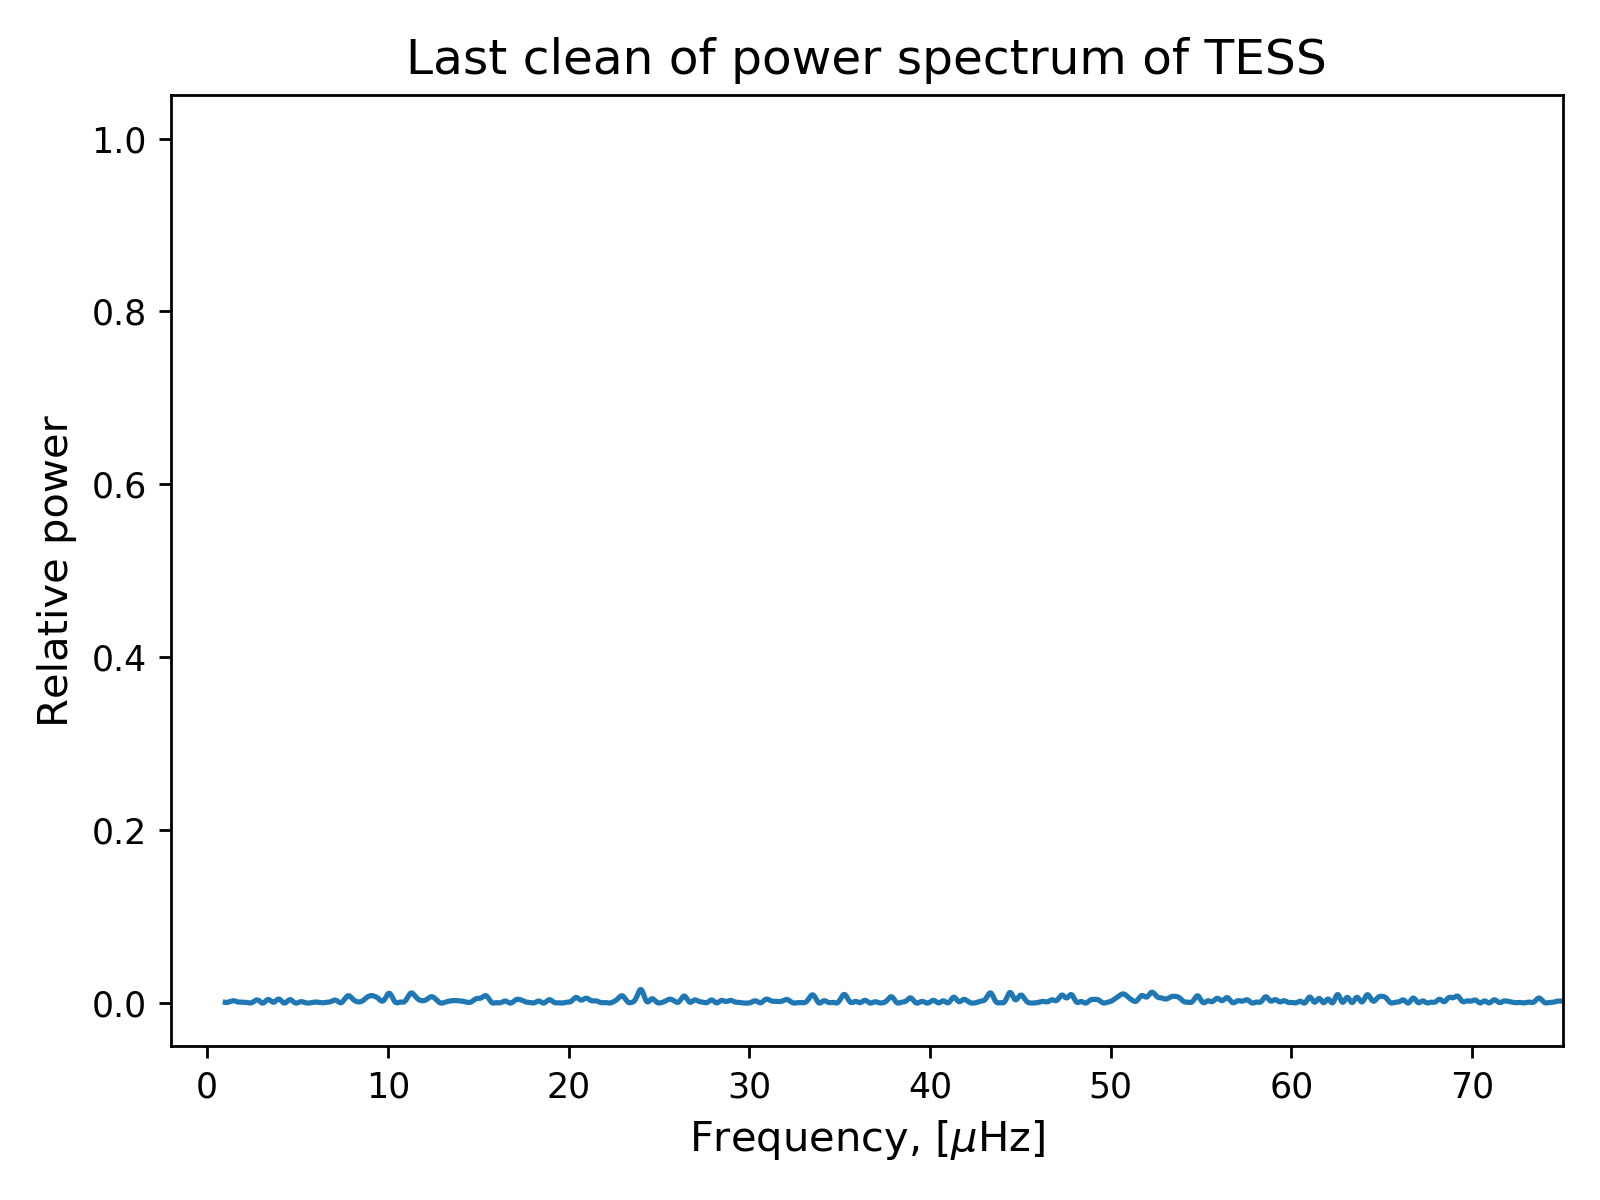

In [205]:
TESS2fig,TESS2ax = plt.subplots(1,1,tight_layout=True)
TESS2ax.set_xlim(-2,75)
TESS2ax.set_ylim(-0.05,1.05)
TESS2ax.set_title('Last clean of power spectrum of TESS')
TESS2ax.set_ylabel('Relative power')
TESS2ax.set_xlabel('Frequency, [$\mu$Hz]')
TESS2ax.plot(tess_clean[-1]['fs']*1e6,tess_clean[-1]['Ps']/np.max(P_TESS))
TESS2fig.savefig('Figure/cleanlast_TESS.pdf')

<IPython.core.display.Javascript object>


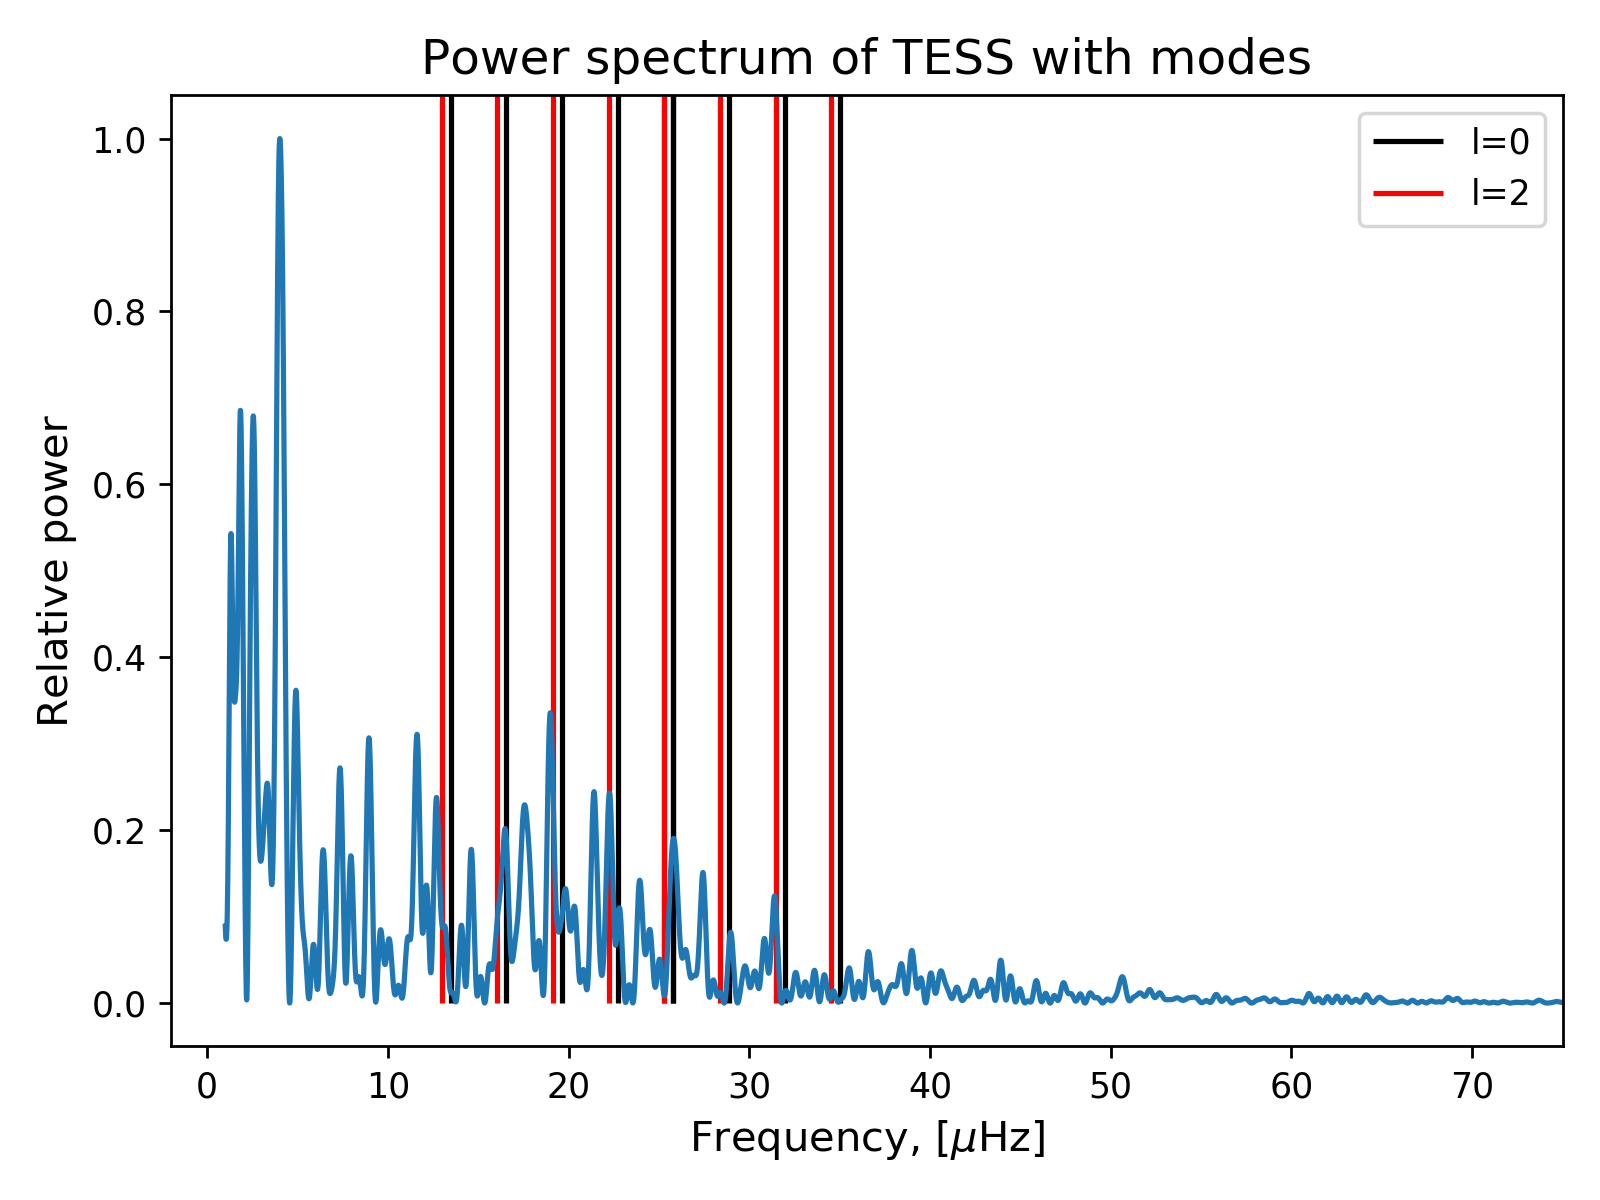

In [204]:
TESS3fig,TESS3ax = plt.subplots(1,1,tight_layout=True)
TESS3ax.set_xlim(-2,75 )
TESS3ax.set_ylim(-0.05,1.05)
TESS3ax.set_title('Power spectrum of TESS with modes')
TESS3ax.set_ylabel('Relative power')
TESS3ax.set_xlabel('Frequency, [$\mu$Hz]')
TESS3ax.plot(f_TESS *1e6, P_TESS/np.max(P_TESS))

v0 = 25.8
dv = 3.08
v2 = 25.3
for i in np.arange(-4,4):
    TESS3ax.vlines(v0+i*dv,0,40)
    TESS3ax.vlines(v2+i*dv,0,40,'r')
TESS3ax.vlines(v0,0.0,40, label = 'l=0')
TESS3ax.vlines(v2,0.0,40,'r', label ='l=2')

TESS3ax.legend()

# Autocorrelation

## Tenerife

In [64]:
P_otsmooth = gaussian_filter(P_ot,sigma = 1)
acsort     = np.where((f_ot>15*1e-6)&(f_ot<45*1e-6))
P_otsmooth = P_otsmooth[acsort]

In [65]:
ot_ac = np.correlate(P_otsmooth, P_otsmooth, mode="full")

In [66]:
freq_shifts = np.linspace(-1,1,len(ot_ac)) * 30*1e-6

## Mt Kent

In [67]:
P_mksmooth = gaussian_filter(P_mk,sigma = 1)
acsort_mk     = np.where((f_mk>15*1e-6)&(f_mk<45*1e-6))
P_mksmooth = P_mksmooth[acsort_mk]

In [68]:
mk_ac = np.correlate(P_mksmooth, P_mksmooth, mode="full")

In [69]:
freq_shiftsmk = np.linspace(-1,1,len(mk_ac)) * 30*1e-6

## SONG

In [70]:
P_SONGsmooth = gaussian_filter(P_SONG,sigma = 1)
acsort_SONG     = np.where((f_SONG>15*1e-6)&(f_SONG<45*1e-6))
P_SONGsmooth = P_SONGsmooth[acsort_SONG]

In [71]:
SONG_ac = np.correlate(P_SONGsmooth, P_SONGsmooth, mode="full")

In [72]:
freq_shiftsSONG = np.linspace(-1,1,len(SONG_ac)) * 30*1e-6

## TESS

In [73]:
P_TESSsmooth = gaussian_filter(P_TESS,sigma = 1)
acsort_TESS  = np.where((f_TESS>15*1e-6)&(f_TESS<35*1e-6))
P_TESSsmooth = P_TESSsmooth[acsort_TESS]

In [74]:
TESS_ac = np.correlate(P_TESSsmooth, P_TESSsmooth, mode="full")

In [75]:
freq_shiftsTESS = np.linspace(-1,1,len(TESS_ac)) * (15-35) *1e-6

## Plotted

<IPython.core.display.Javascript object>


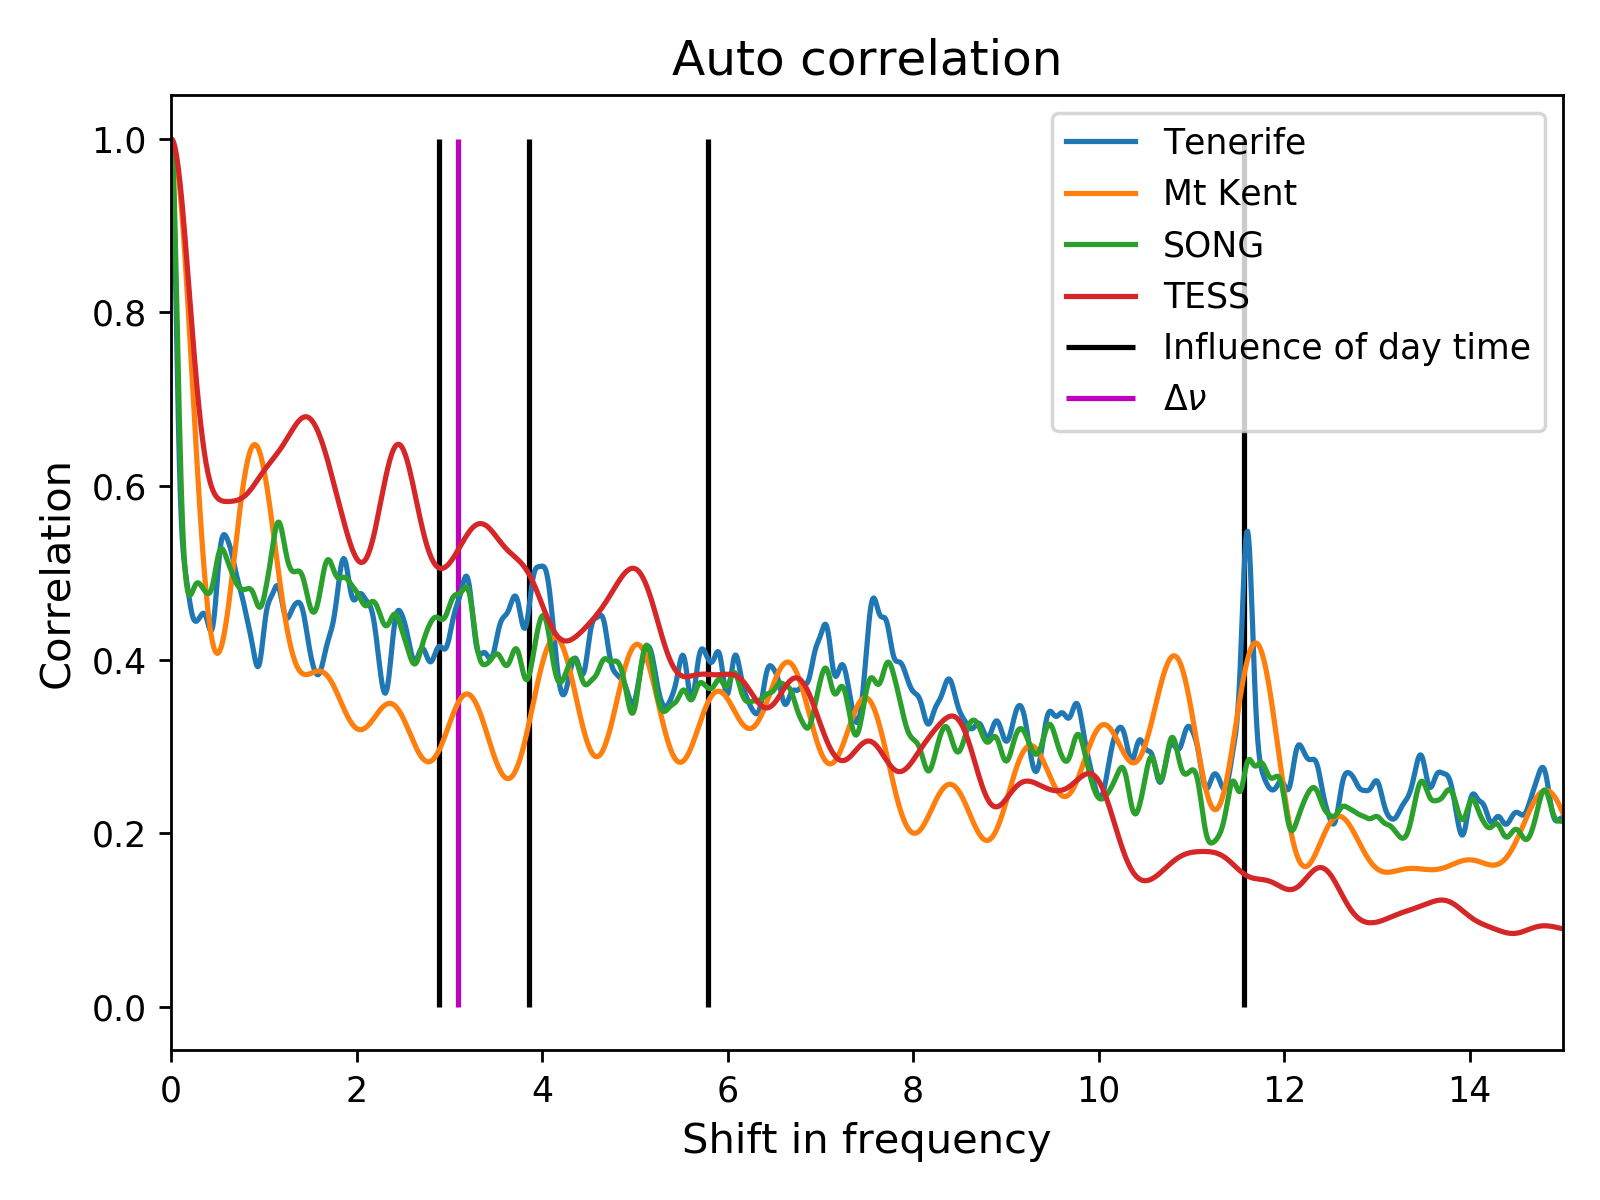

In [231]:
fig4,ax4 = plt.subplots(1,1,tight_layout=True)
ax4.set_title('Auto correlation')
ax4.set_xlabel('Shift in frequency')
ax4.set_ylabel('Correlation')
ax4.set_xlim(0,15)
ax4.plot(freq_shifts*1e6,ot_ac/np.max(ot_ac), label='Tenerife')
ax4.plot(freq_shiftsmk*1e6,mk_ac/np.max(mk_ac), label='Mt Kent')
ax4.plot(freq_shiftsSONG*1e6,SONG_ac/np.max(SONG_ac), label='SONG')
#ax4.plot(freq_shiftsSONG2*1e6,SONG_ac2/np.max(SONG_ac2), label='SONG2')
ax4.plot(freq_shiftsTESS*1e6,TESS_ac/np.max(TESS_ac), label='TESS')
ax4.vlines(11.57,0.0,1)
ax4.vlines(11.57/2,0.0,1, label = 'Influence of day time')
ax4.vlines(11.57/3,0.0,1)
ax4.vlines(11.57/4,0.0,1)
ax4.vlines(Dv,0.0,1, 'm', label = r'$\Delta \nu$')
ax4.legend()
fig4.savefig('Figure/autocorrelation.pdf')

## Finding parameters for the star

In [119]:
freq0  = np.array([13.4388,19.7596,22.6028,25.799,31.8622,44.3368])
order0 = np.array([1,3,4,5,7,11])

freq1  = np.array([14.3797,21.1219,23.9434,26.9738,29.833,33.5995,39.3008,45.3616,49.022,52.2065])
order1 = np.array([1,3,4,5,6,7,9,11,12,13])

freq2  = np.array([16.053,22.1592,25.2694,31.3136,34.5098,37.5342,40.5873])
order2 = np.array([2,4,5,7,8,9,10])

In [120]:
def func(x,a,b):
    return a*x+b

popt0,pcov0 = curve_fit(func,order0,freq0,p0=[3,0],sigma = freq0*0.0+0.1, absolute_sigma=True)
fit0 = func(order0,popt0[0],popt0[1])

popt1,pcov1 = curve_fit(func,order1,freq1,p0=[3,0],sigma = freq1*0.0+0.1, absolute_sigma=True)
fit1 = func(order1,popt1[0],popt1[1])

popt2,pcov2 = curve_fit(func,order2,freq2,p0=[3,0],sigma = freq2*0.0+0.1, absolute_sigma=True)
fit2 = func(order2,popt2[0],popt2[1])

In [256]:
Teff = 4870 #K
Teffsun = 5772 #K

Dv  = (popt0[0]+popt1[0]+popt2[0])/3
Dverr = np.sqrt(pcov0[0,0] + pcov1[0,0] + pcov2[0,0])/3
Dvsun = 135

vmax = f_SONG[np.where(SONG_smoothed/np.max(P_SONG) == np.max(SONG_smoothed/np.max(P_SONG)))][0]*1e6  #+-1
vmaxsun = 3100

In [122]:
R = vmax/vmaxsun * (Dv/Dvsun)**(-2) * (Teff/Teffsun)**(0.5)

M = (vmax/vmaxsun)**(3) * (Dv/Dvsun)**(-4) * (Teff/Teffsun)**(1.5)

logg = np.log10((vmax/vmaxsun)*(Teff/Teffsun)**(0.5)) + 4.436

Mass = ((Dv/Dvsun)**(2) * 12.2**3)

In [257]:
R,M,logg,Mass, Dv, Dverr, vmax

(12.433480218921163,
 1.0077382008217806,
 2.250162306384522,
 0.9520266169771765,
 3.091139236902188,
 0.006941073570156713,
 23.906045302265113)